# Graduate Student Project Submission for Leena Godbole
## CSC-410 / April 23, 2024

Data source:  UC Berkley Machine Learning Repository \
Dataset: 'Mushroom' - 22 features, 8124 observations, categorical data (edible / inedible)

Project Learning Goals:  I would like to utilize machine learning techniques that I have not used at the project level before in the MSIA program in order to classify the mushrooms into 'edible' vs 'inedble'.  I will use SVMs, RF, and a novel method of my own making to try to classify these mushrooms and compare the model evaluation metrics at the end.

In [24]:
#importing dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 

(8124, 22)

In [2]:
# libaries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import patoolib
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
# evaluate random forest algorithm for classification
from numpy import mean
from numpy import std

from matplotlib import pyplot
import statistics
from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, confusion_matrix


# settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# seed
random.seed(42)

In [3]:
# Checking for missing data

print(X.isnull().sum())
print('\n')
print(y.isnull().sum())

print('\nStalk root has some NANs, I will explore further')

cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64


poisonous    0
dtype: int64

Stalk root has some NANs, I will explore further


In [4]:
stalkRootPercent = round(X['stalk-root'].value_counts().sum() / X.shape[0], 3)*100 # percent of real data in stalk root columbn
stalkRootNAN = 100 - stalkRootPercent
print('The stalk root has ' + str(stalkRootPercent) + '% real data and ' + str(stalkRootNAN) + '% NANs.')
print('I will drop the column')

X.drop(['stalk-root'], axis = 1, inplace = True)

The stalk root has 69.5% real data and 30.5% NANs.
I will drop the column


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\2078327111.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['stalk-root'], axis = 1, inplace = True)


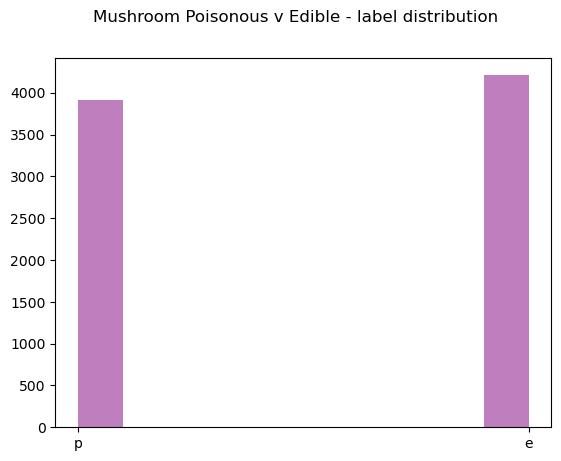

The dataset appears to be balances, and no up / down sampling will be done


In [5]:
# Checking the balance of the labeled data (y)
plt.hist(y['poisonous'], alpha=0.5, color = 'purple')
plt.suptitle('Mushroom Poisonous v Edible - label distribution')
plt.show()

print('The dataset appears to be balances, and no up / down sampling will be done')

In [6]:
# All of the X feature data is categorical and nominal, it will have tobe recoded in order to run through the python algorithms

X.dtypes

cap-shape                   object
cap-surface                 object
cap-color                   object
bruises                     object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

In [7]:
# regular encoding versus one hot encoding
# Since all of this data is nominal, I will opt for one hot encoding

# saving the column headers as a list, as all the features are categorical objects so one hot encoding will have to be done on the whole frame
cols = list(X.columns.values)

features = pd.get_dummies(X, columns = cols)  # onehotencoding
features = features.astype(int) # turning True False to 1 / 0

# repeating for the label data
label = pd.get_dummies(y, columns = ['poisonous'])
label.drop('poisonous_e', axis = 1, inplace = True)
label = label.astype(int)

print('The original dataframe has the following dimensions:  ' + str(X.shape))
print('The one hot encoded DF has the following dimension:  ' + str(features.shape))

The original dataframe has the following dimensions:  (8124, 21)
The one hot encoded DF has the following dimension:  (8124, 112)


In [8]:
# seperating arrays into train and test

#train, test = train_test_split(df, test_size=0.2)

X_train, X_test, y_train, y_test  = train_test_split(features, # dataframe
                                                     label, # labels
                                                     stratify = label, # maintains class balance in each split
                                                     test_size=0.2) # 80/20 split

# Checking train / test splits are correct

print('X_train dimension are ' + str(X_train.shape))
print('y_train dimension are ' + str(y_train.shape) +'\n')

print('X_test dimension are ' + str(X_test.shape))
print('y_test dimension are ' + str(y_test.shape))


X_train dimension are (6499, 112)
y_train dimension are (6499, 1)

X_test dimension are (1625, 112)
y_test dimension are (1625, 1)


### Function - Plot Confusion Matricies
####  This is a function used to Plot Confusion Matricies that are very pretty
#### Code pulled from scikit-learn.org, this is the only code not generated by myself in this assignmemt

In [9]:
#  Code below is pulled from scikit-learn.org to plot confusion matricies

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

### 

### Function - SVM Classifier

#### This is a funtion that does the following:

1) creates a SVM model
2) fits the model with the train data 
3) generates the confusion matricies for the train & test data 
4) records model metrics in a summary table 
5) saves the pretty confusion matricies with specific file names 

Inputs for function:  \
    x = train dataset features \
    Y = train dataset label \
    x_test = test dataset features \
    Y_test = test dataset label \
    label = dataset name e.g. 'Mushroom Dataset' \
    classLabels = Y labels, used for confusion matrix.  e.g. ['Image0', 'Image1', 'image2'] \
    kernelFunction = what SVM kernel function to use

In [10]:
# Empty lists to store metrics for each model as they are calculated
ModelMetrics = []

def SVMModel(x, Y, x_test, Y_test, label,  classLabels, kernelFunction):
        # Defining model    
        model = SVC(kernel = kernelFunction)
        modelName = 'SVM - ' + kernelFunction + ' kernel'


        testTitle = 'Confusion Matrix - ' + modelName + ' - ' +  label +  ' Test Data'  # Used to name plots
        trainTitle = 'Confusion Matrix - ' + modelName + ' - ' + label +  'Train Data' # used to name plots



        model.fit(x, Y)
        
        Train_Predict = model.predict(x)
        Test_Predict = model.predict(x_test)

        cm_test = confusion_matrix(Y_test, Test_Predict.round())
        cm_train = confusion_matrix(Y, Train_Predict.round())


        ModelMetrics.append([label,
                             modelName,
                             (metrics.accuracy_score(Y, Train_Predict.round())), 
                             (metrics.f1_score(Y, Train_Predict.round(), average='weighted')),
                             (metrics.accuracy_score(Y_test, Test_Predict.round())), 
                             (metrics.f1_score(Y_test, Test_Predict.round(), average='weighted'))])



        plot_confusion_matrix(cm_train, classLabels , title = trainTitle)
        plt.savefig(trainTitle)

        plot_confusion_matrix(cm_test, classLabels, title = testTitle)
        plt.savefig(testTitle)
        

C:\Users\leena\anaconda3\envs\MSIA\Lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[842   0]
 [  0 783]]


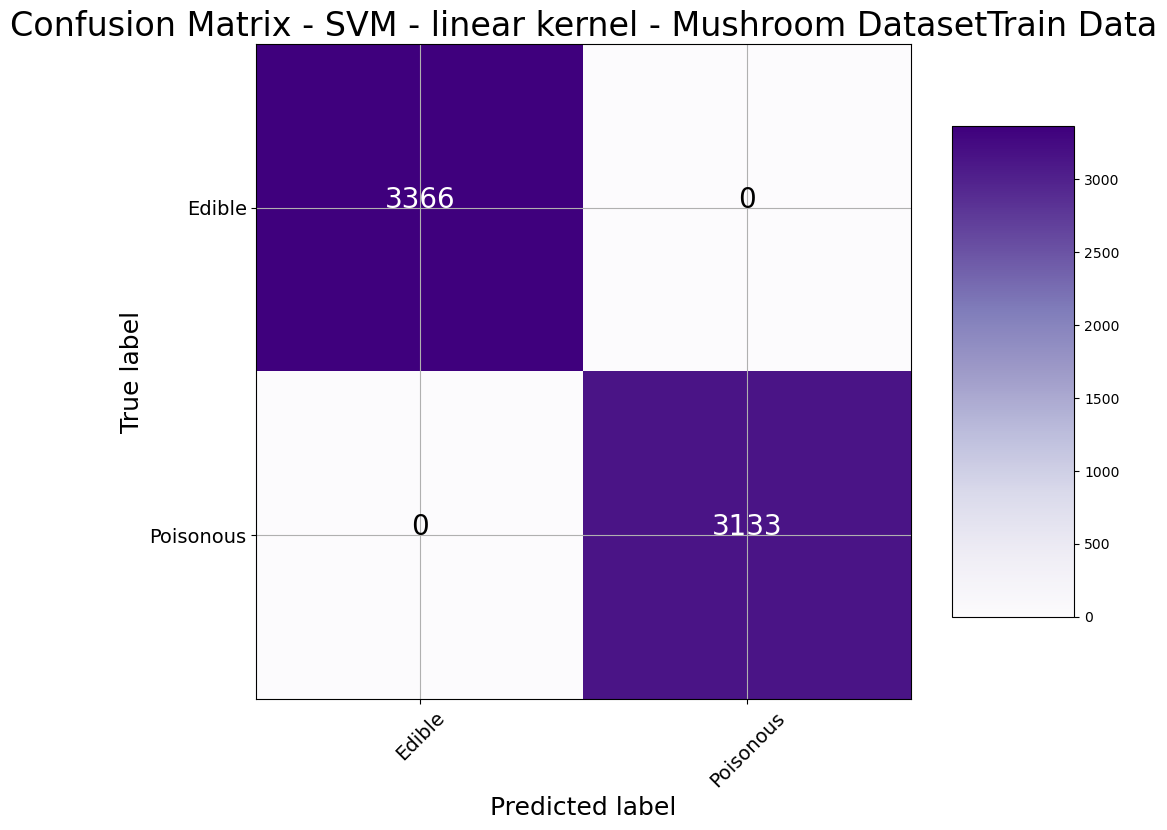

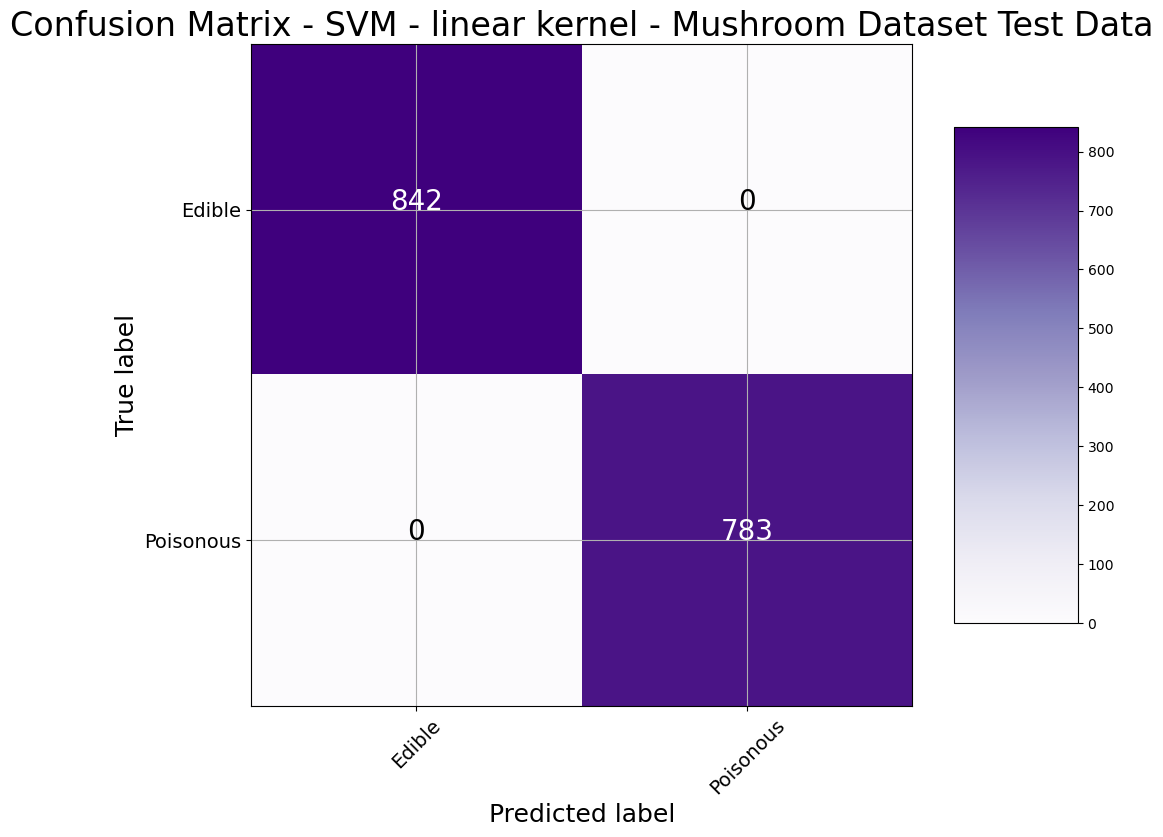

In [11]:
SVMModel(X_train, y_train, X_test, y_test, 'Mushroom Dataset', ['Edible', 'Poisonous'], 'linear')

### Function -  Random Forest Classifier
#### This is a funtion that does the following:

1) creates a Random Forest Classifier, n_estimators = nTrees
2) fits the model with the train data 
3) generates the confusion matricies for the train & test data 
4) records model metrics in a summary table 
5) saves the pretty confusion matricies with specific file names 

Inputs for function:  \
    x = train dataset features \
    Y = train dataset label \
    x_test = test dataset features \
    Y_test = test dataset label \
    label = dataset name, e.g. 'Mushroom Dataset' \
    classLabels = Y labels, used for confusion matrix.  e.g. ['edible', 'poisonous'] \
    ntrees = number of trees in the forest \ 'Image1', 'image2']
ntrees = number of trees in the forest 'Image1', 'image2']
ntrees = number of trees in the forest

In [12]:
def RandomForestModel(x, Y, x_test, Y_test, label,  classLabels, ntrees):
        # Model Parameters - used to change what dataset is getting modeled
       # x = image012_X_train
       # Y = image012_y_train
       # x_test = image012_X_test
       # Y_test = image012_y_test
       # label = 'Image012'
       # classLabels = ['Image0', 'Image1', 'image2']

        # Defining model    
        model = RandomForestClassifier(n_estimators=ntrees,
                                       random_state=42,
                                       max_features = 'sqrt',
                                       n_jobs=-1, verbose = 1)
        
        modelName = 'RF: nTrees = ' + str(ntrees)


        testTitle = 'Confusion Matrix - ' + modelName  +  ' ' + label +  ' Test Data'  # Used to name plots
        trainTitle = 'Confusion Matrix - ' + modelName  + label + ' ' +  'Train Data' # used to name plots



        # K fold x validation
        # cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state=1)
        # n_scores = cross_val_score(model, 
        #                          image01_X_train, 
        #                           image01_y_train, 
        #                           scoring='accuracy', 
        #                           cv=cv, n_jobs=-1, 
        #                           error_score='raise')


        model.fit(x, Y)
        Train_Predict = model.predict(x)
        Test_Predict = model.predict(x_test)

        cm_test = confusion_matrix(Y_test, Test_Predict)
        cm_train = confusion_matrix(Y, Train_Predict)


        ModelMetrics.append([label,
                             modelName,
                             metrics.accuracy_score(Y, Train_Predict), 
                             metrics.f1_score(Y, Train_Predict, average='weighted'),
                             metrics.accuracy_score(Y_test, Test_Predict), 
                             metrics.f1_score(Y_test, Test_Predict, average='weighted')])


        # confusion matricies
        plot_confusion_matrix(cm_train, classLabels , title = trainTitle)
        plt.savefig(trainTitle)
        plot_confusion_matrix(cm_test, classLabels, title = testTitle)
        plt.savefig(testTitle)

        plt.clf()    

        # feature importance
        pd.Series(model.feature_importances_, index= x_test.columns).nlargest(14).plot(kind='barh')

C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[842   0]
 [  0 783]]


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[842   0]
 [  0 783]]


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[842   0]
 [  0 783]]


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[842   0]
 [  0 783]]


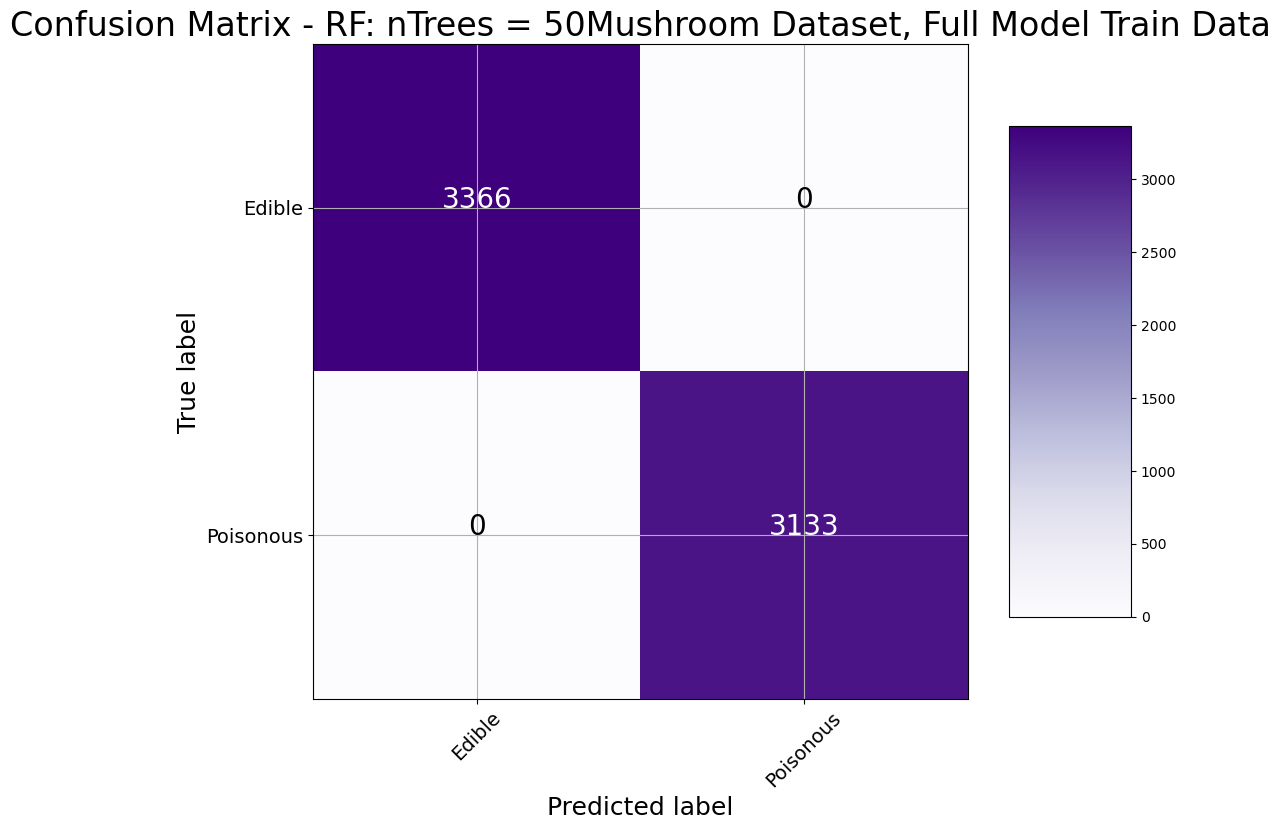

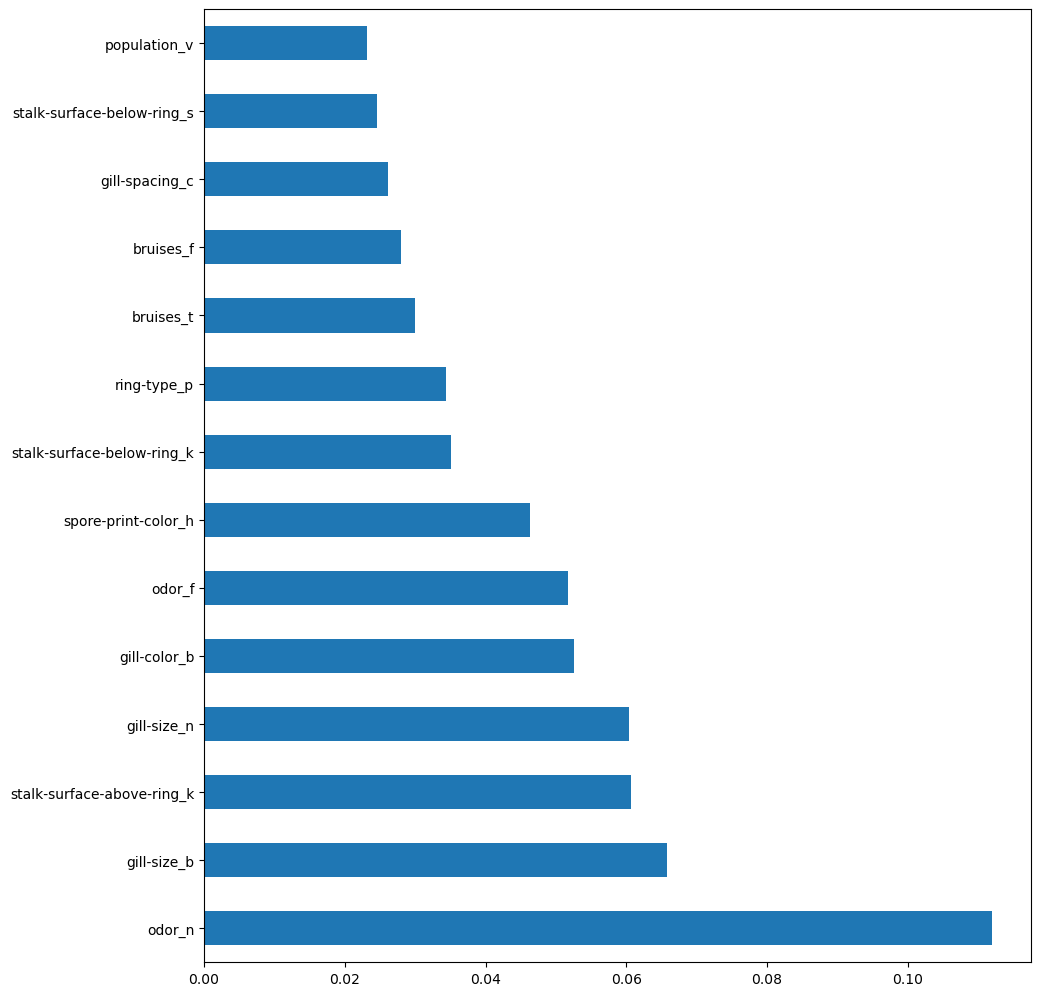

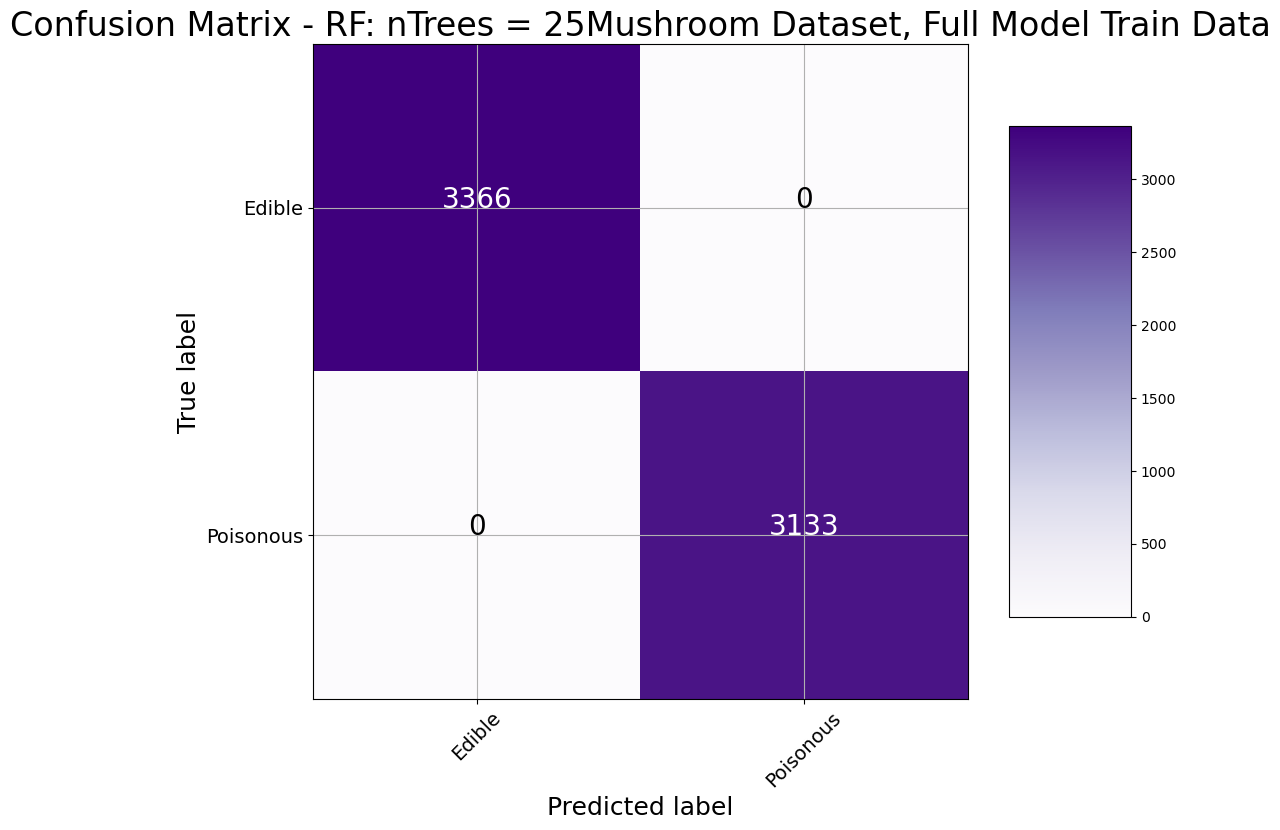

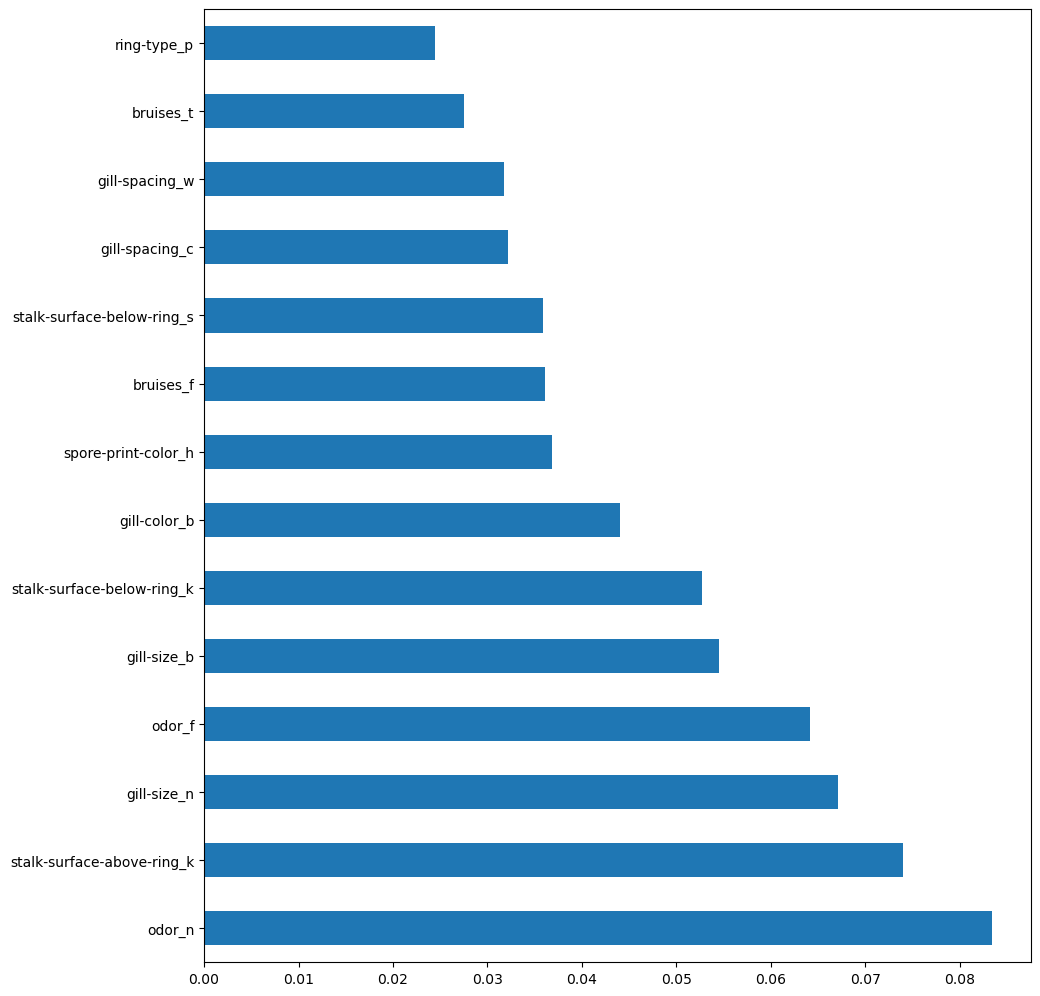

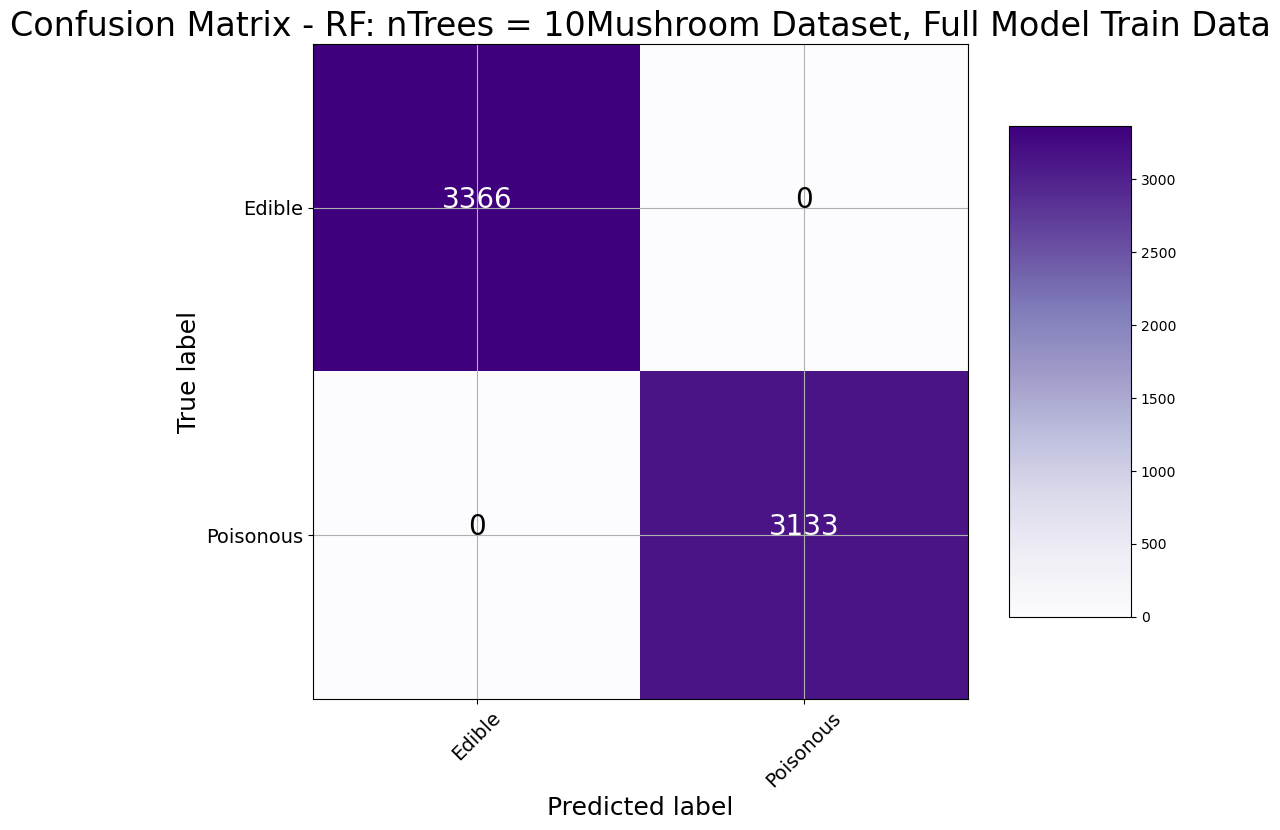

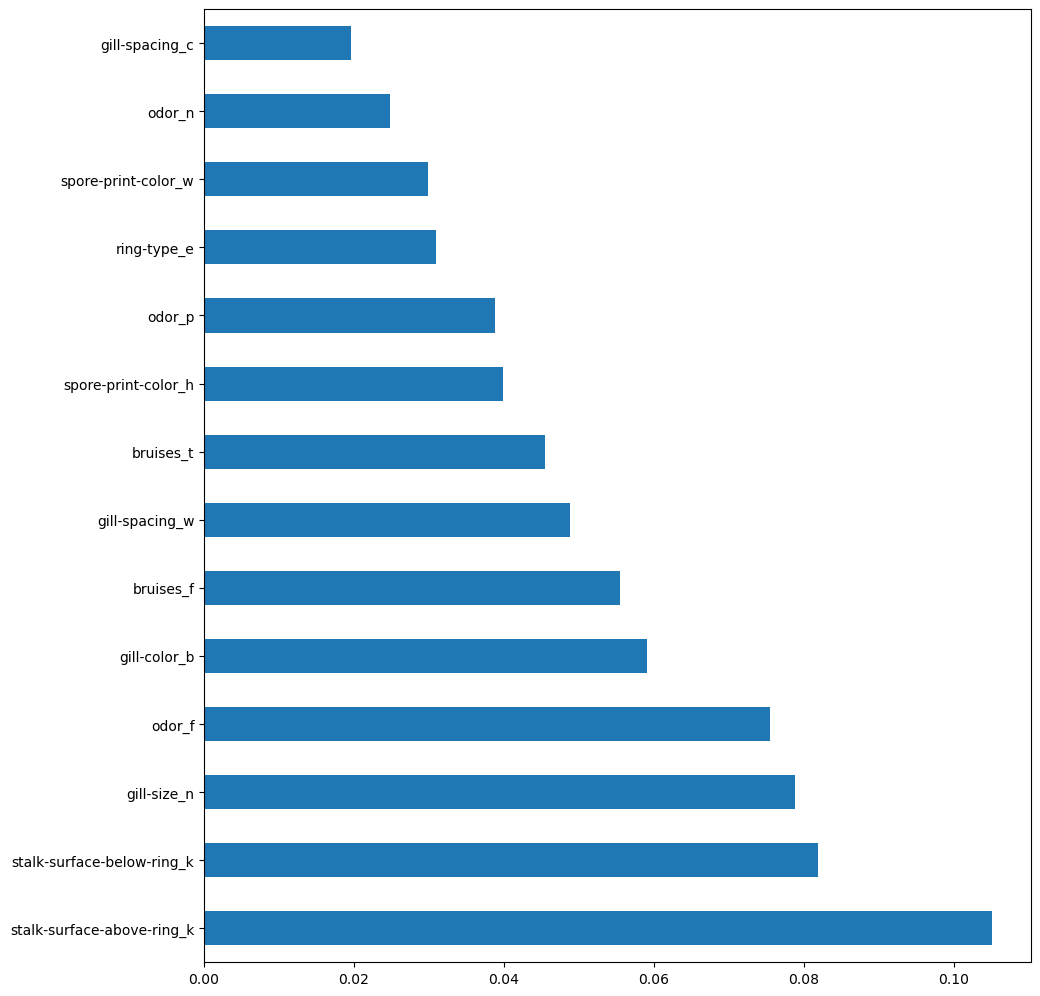

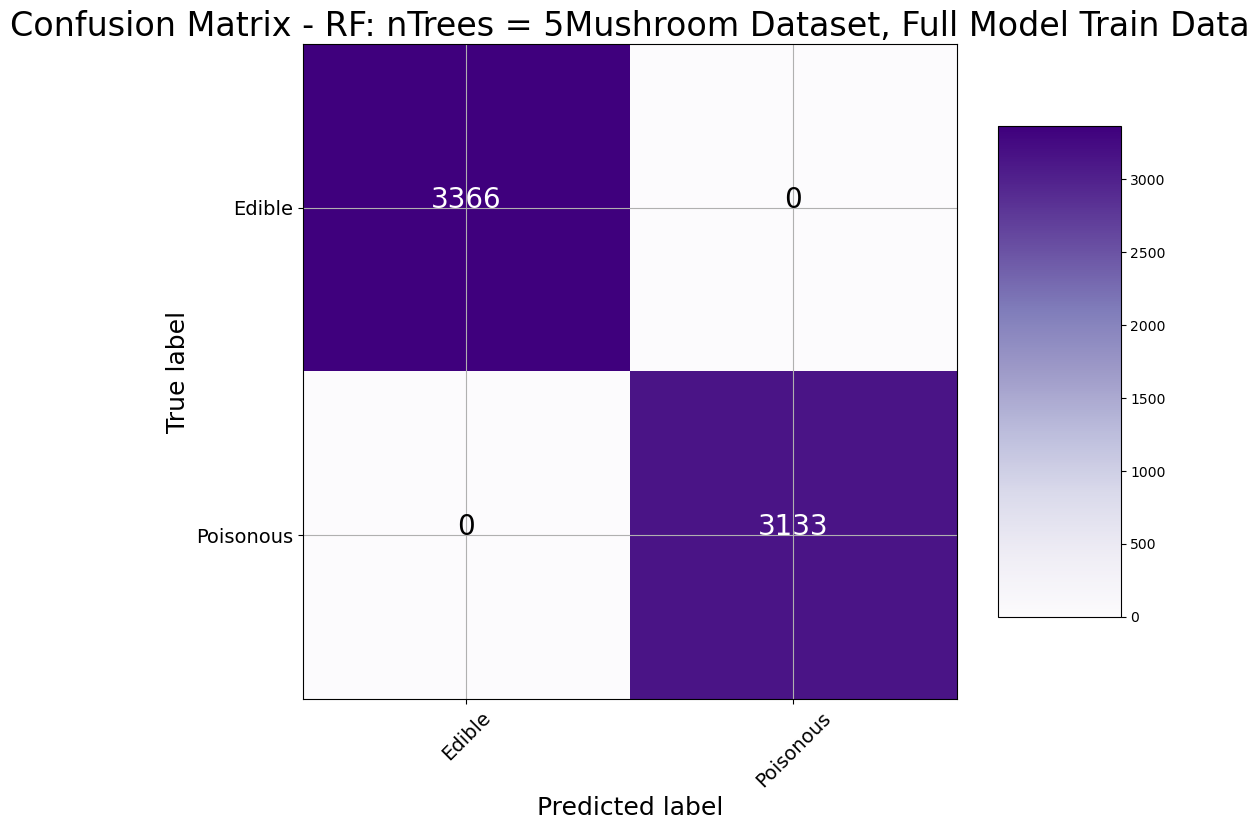

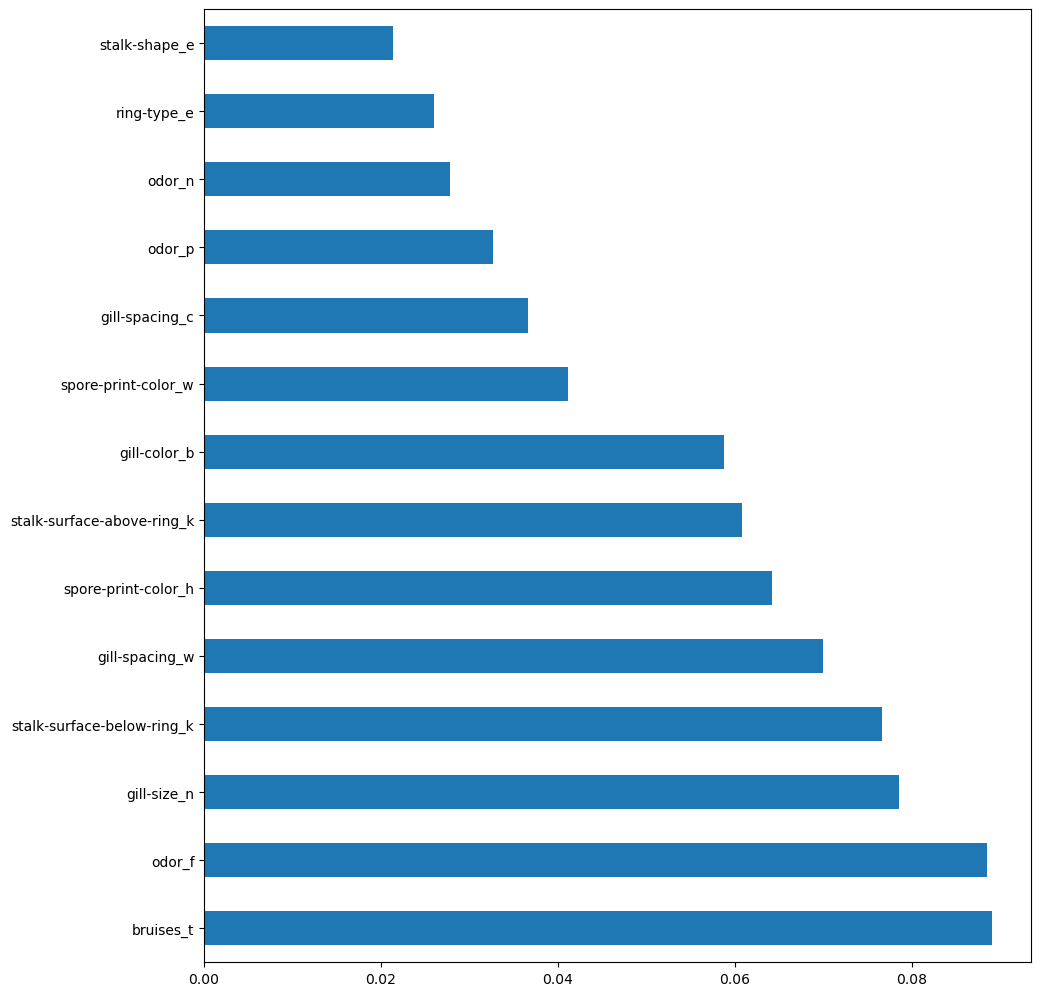

In [13]:
RandomForestModel(X_train, y_train, X_test, y_test, 'Mushroom Dataset, Full Model', ['Edible', 'Poisonous'], 50)
RandomForestModel(X_train, y_train, X_test, y_test, 'Mushroom Dataset, Full Model', ['Edible', 'Poisonous'], 25)
RandomForestModel(X_train, y_train, X_test, y_test, 'Mushroom Dataset, Full Model', ['Edible', 'Poisonous'], 10)
RandomForestModel(X_train, y_train, X_test, y_test, 'Mushroom Dataset, Full Model', ['Edible', 'Poisonous'], 5)

C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[842   0]
 [  0 783]]


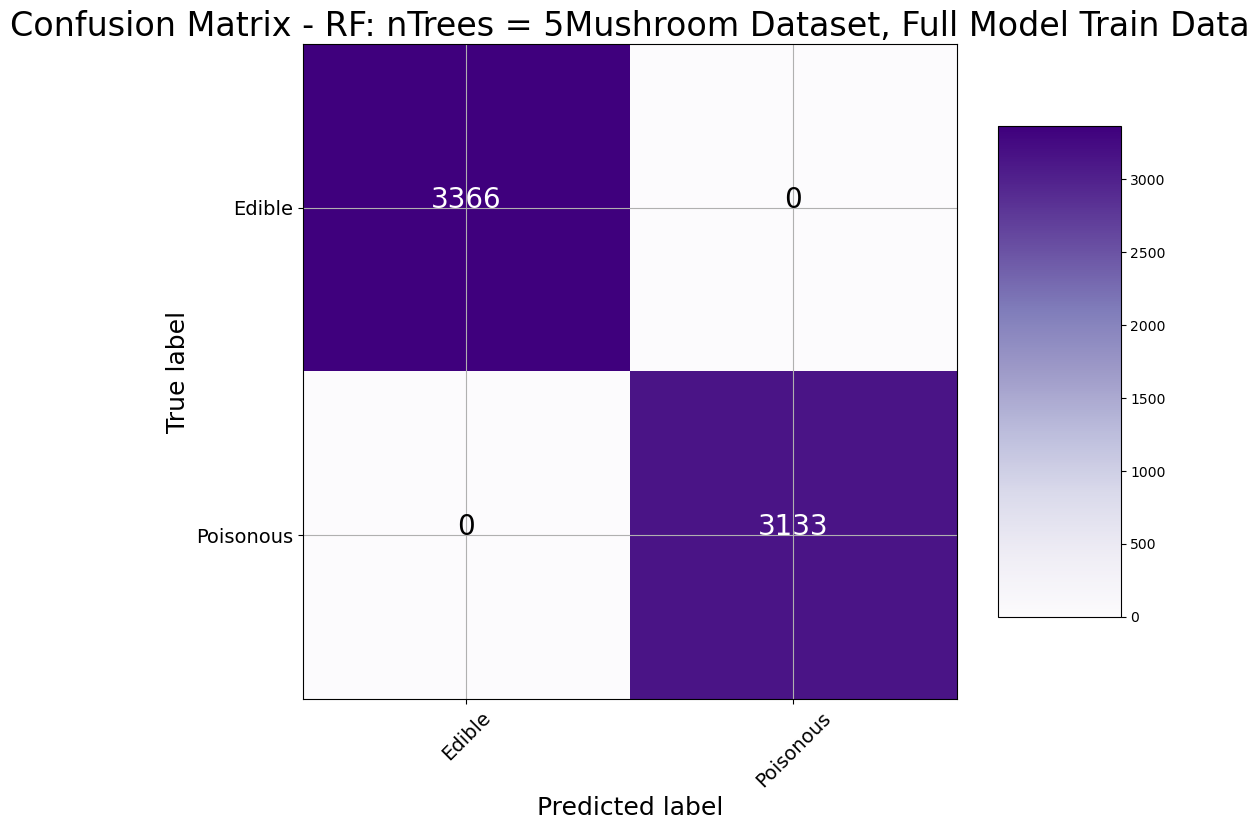

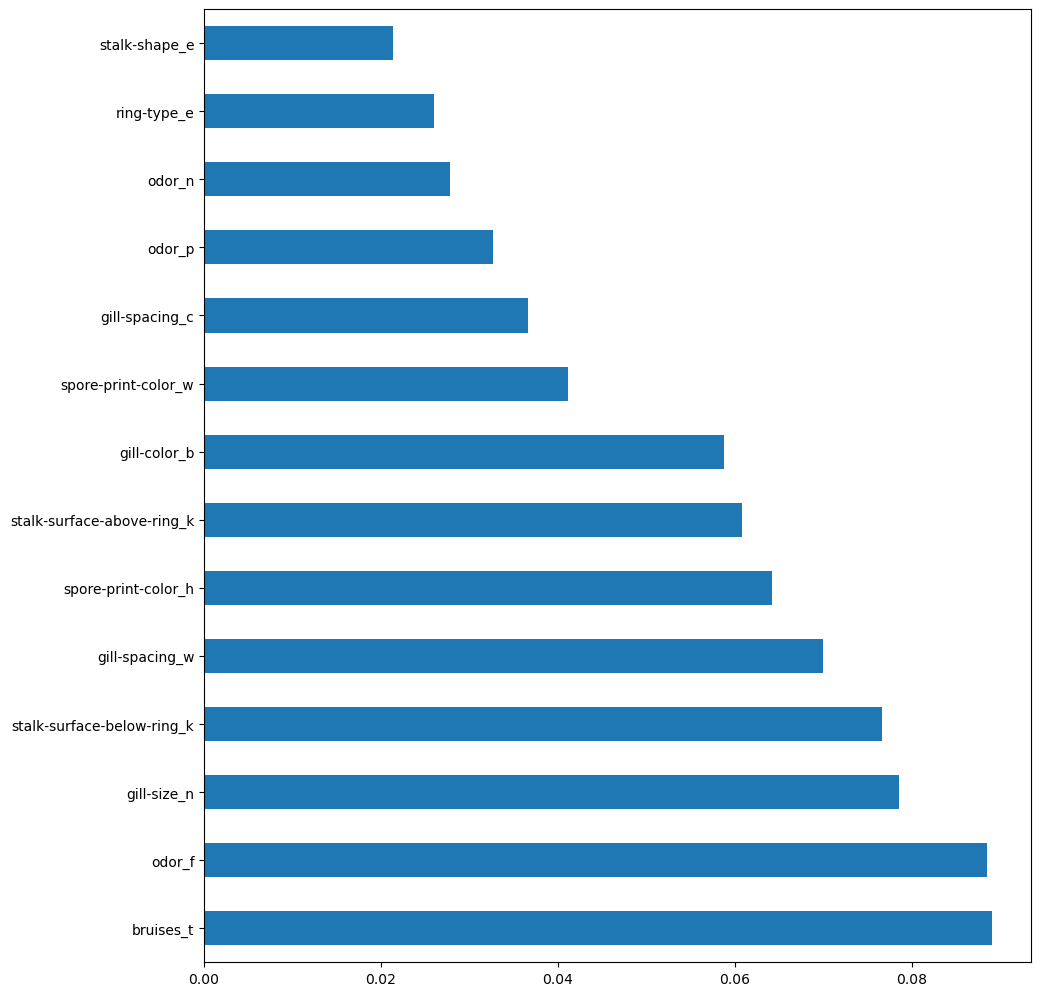

In [14]:
#  feature importances of the full random forest model 
RF = RandomForestModel(X_train, y_train, X_test, y_test, 'Mushroom Dataset, Full Model', ['Edible', 'Poisonous'], 5)



### Function -  PCA Datasets

#### This is a funtion that does the following:

1) creates a standard scaler
2) scales the input data
3) creates a PCA with 'cmp' components
4) transforms scaled data 
5) returns the PCA as a dataframe

Inputs for function:  \
    trainSet = X dataSet to transform  \
    cmp = number if principal components to use \


In [15]:
# introducing PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing as pp



def PricinpalComponent(dataSet, cmp): # trainset = train dataset, cmp = number of components
    scalar = StandardScaler()
    temp = scalar.fit_transform(dataSet)
    pcal = PCA(n_components = cmp)
    temp = pcal.fit_transform(temp)


    df = pd.DataFrame(temp, index = dataSet.index)
    
    return df

In [16]:
# Performing PCA on the train and test splits
numFeatures = 25

X_train_PCA = PricinpalComponent(X_train, numFeatToures)
X_test_PCA = PricinpalComponent(X_test, numFeatures)


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[840   2]
 [ 51 732]]


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[840   2]
 [ 36 747]]


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[839   3]
 [ 39 744]]


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   1 3132]]
Confusion matrix, without normalization
[[812  30]
 [ 40 743]]


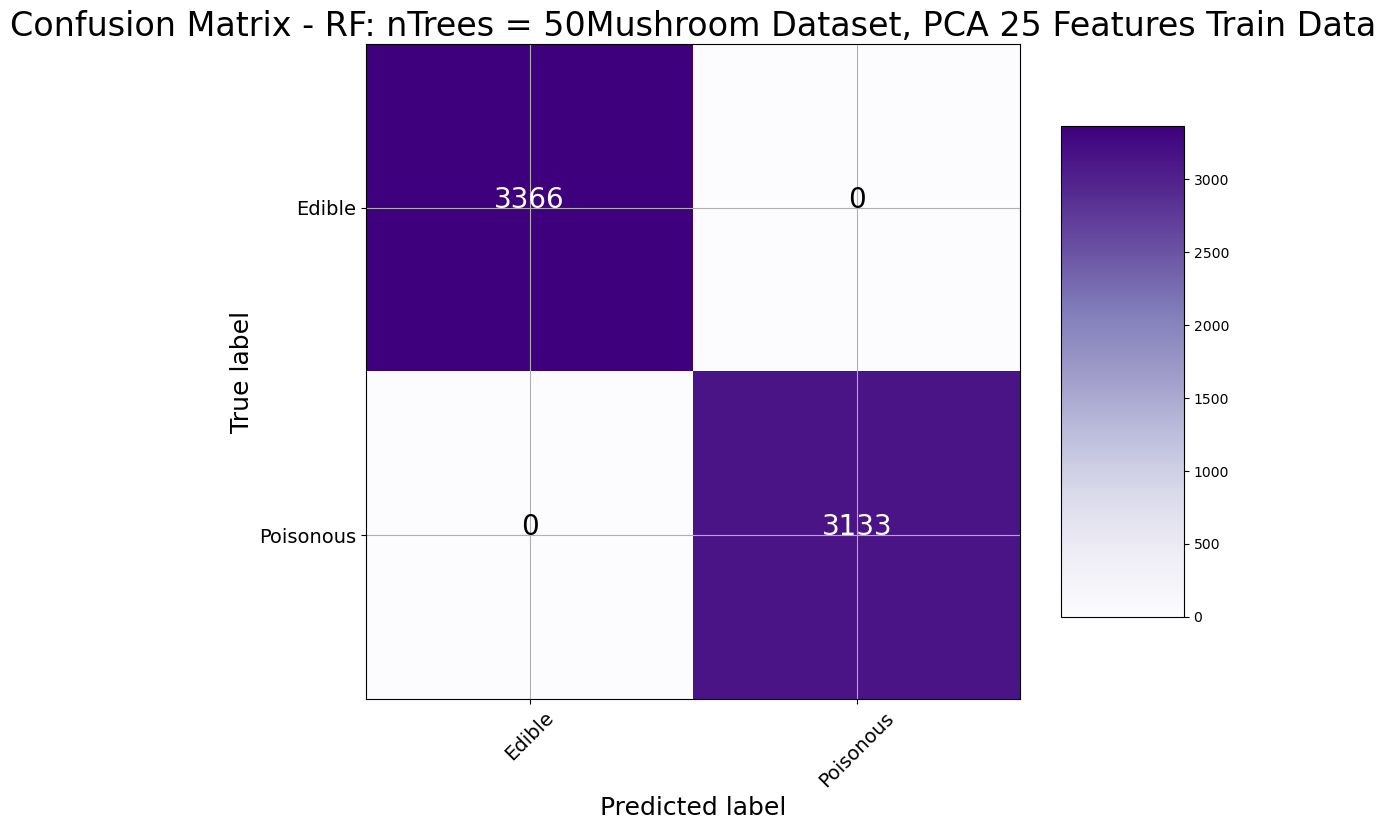

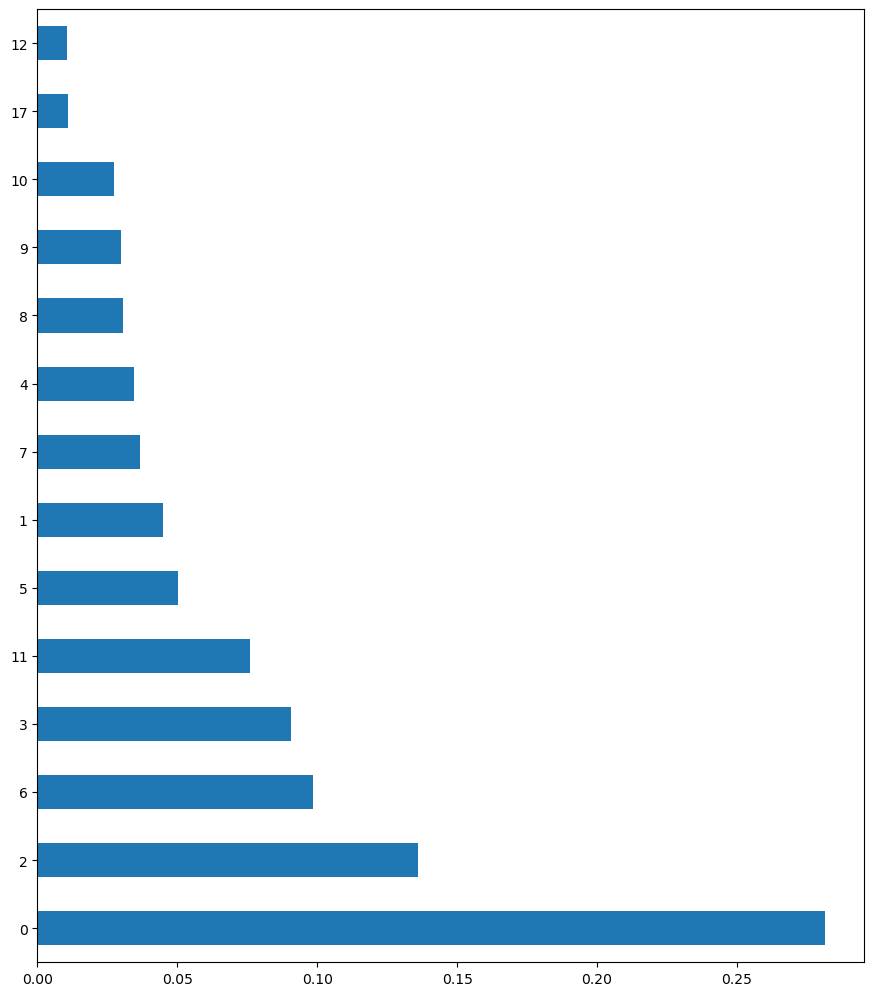

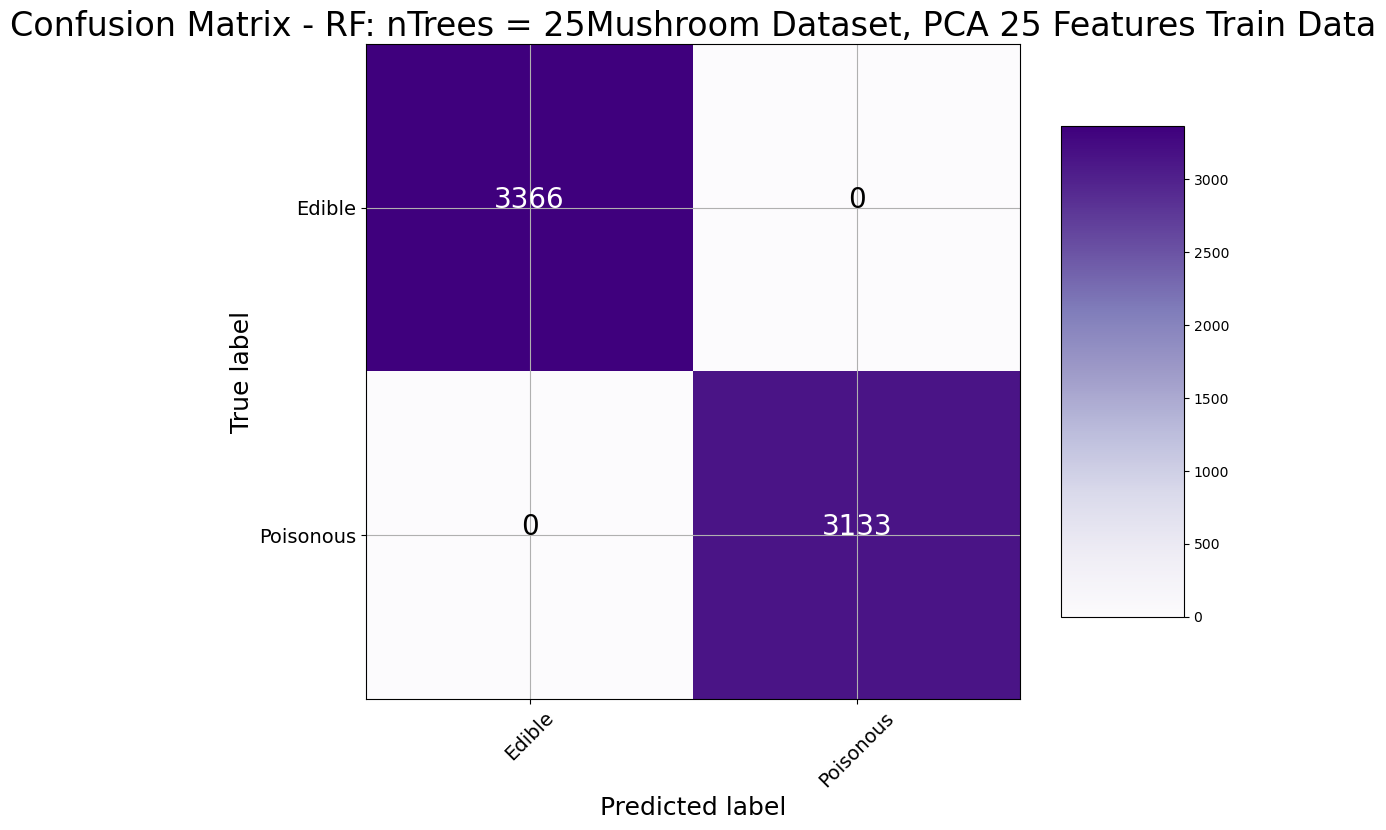

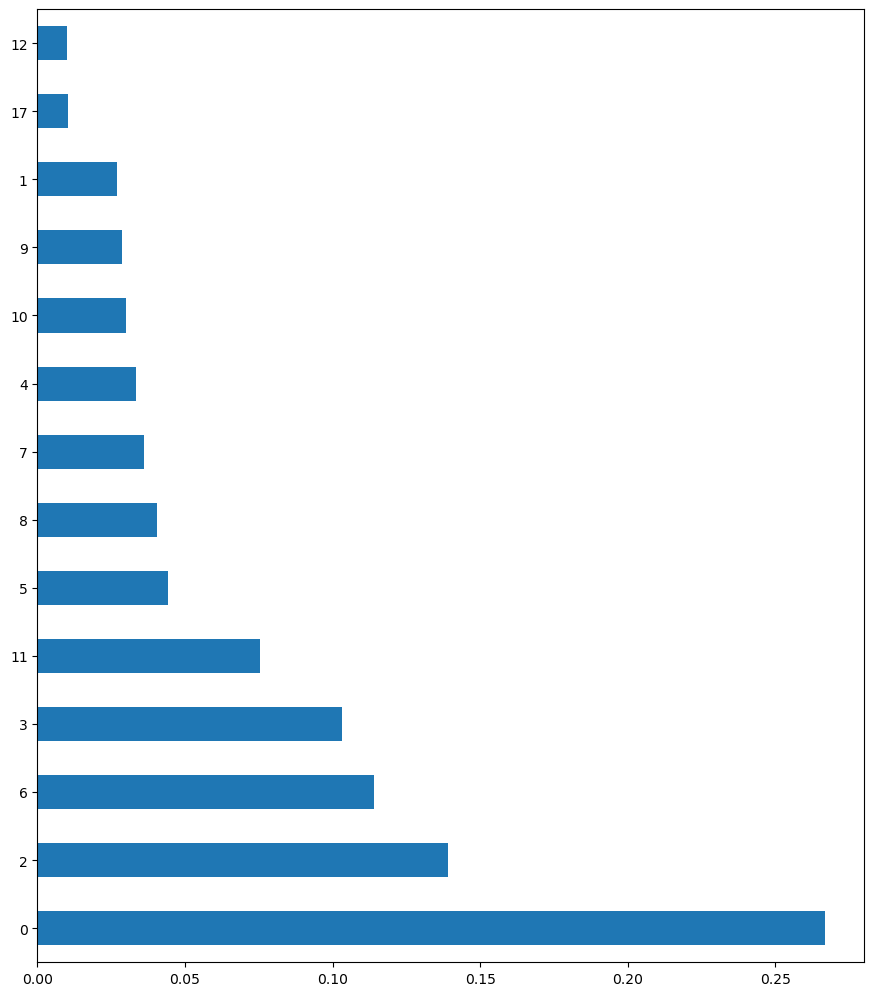

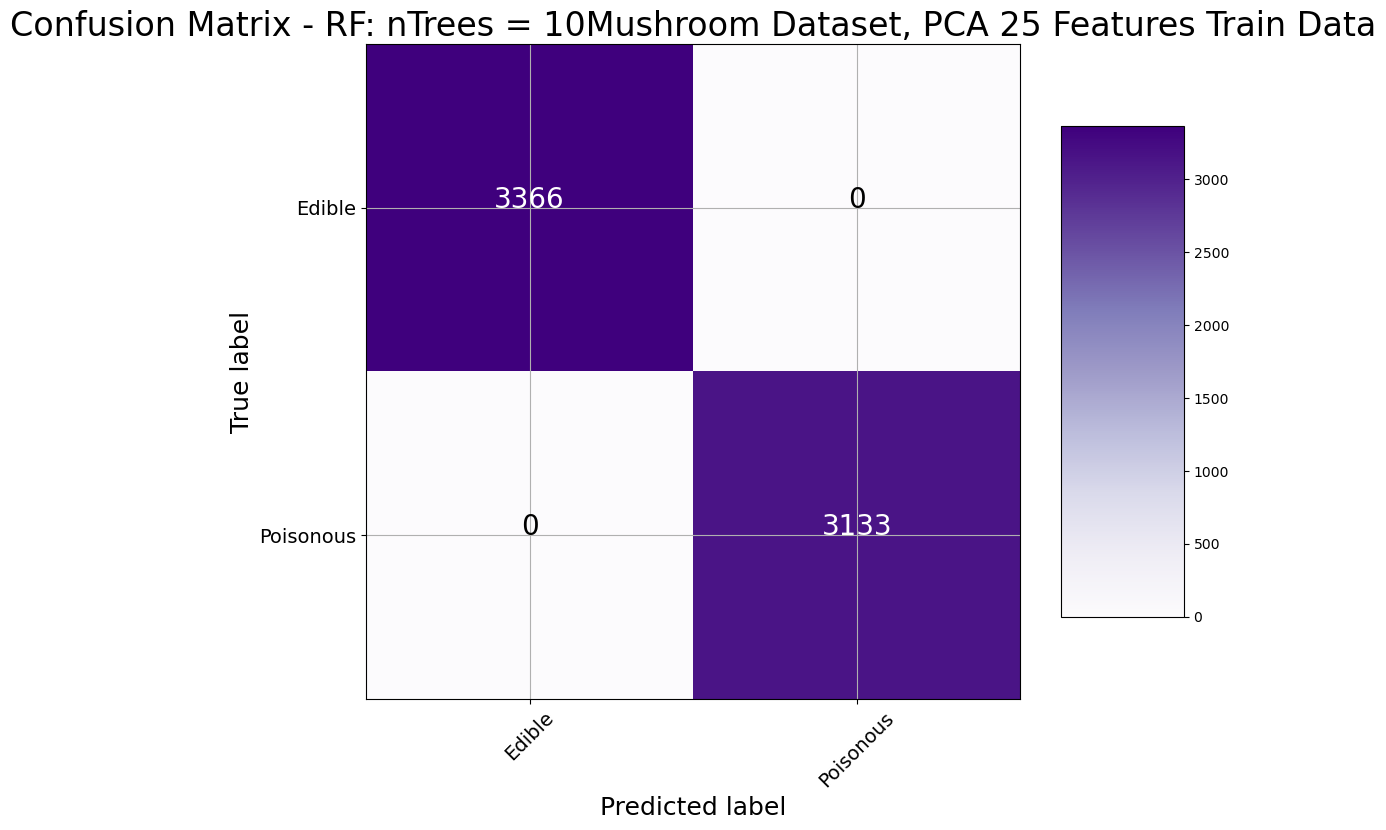

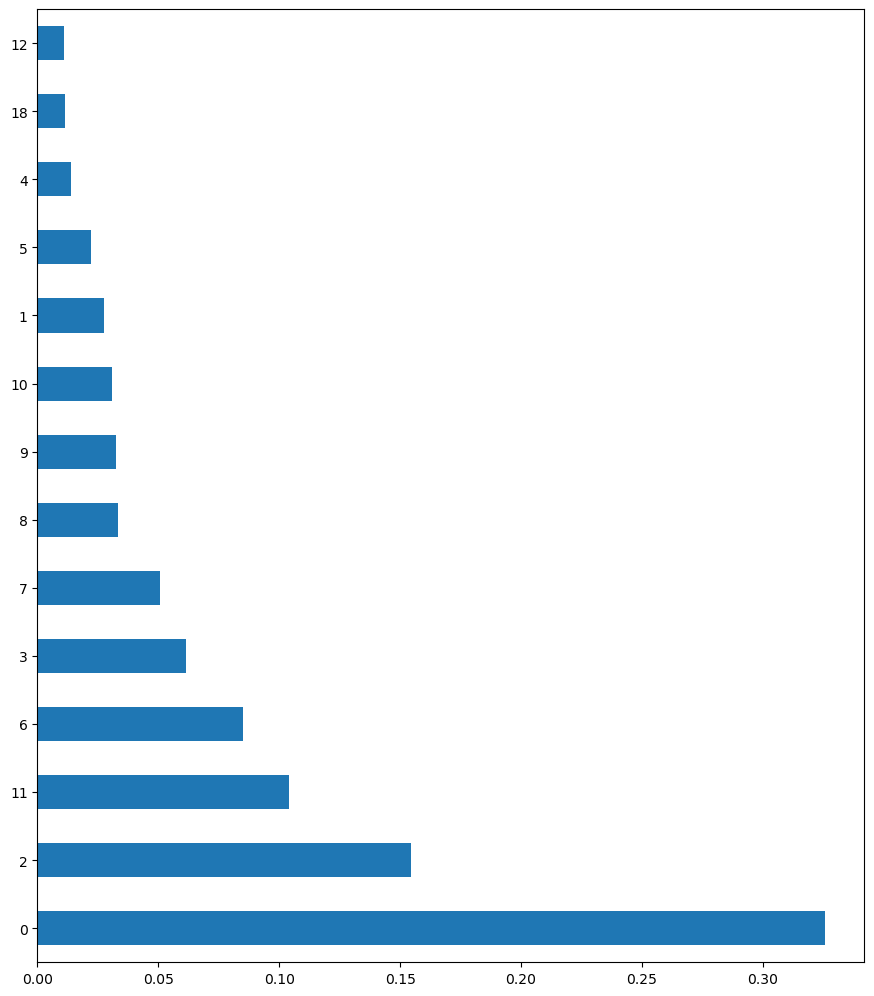

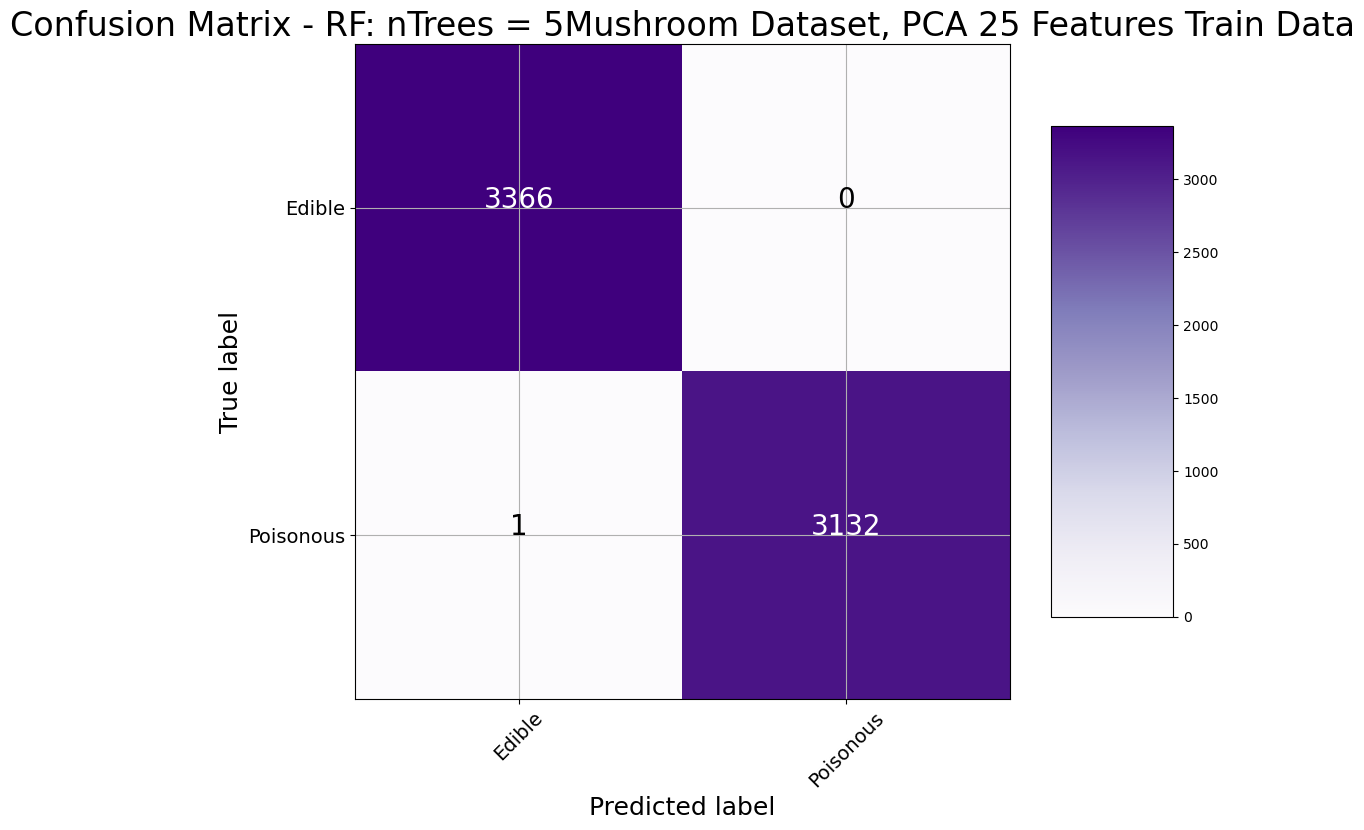

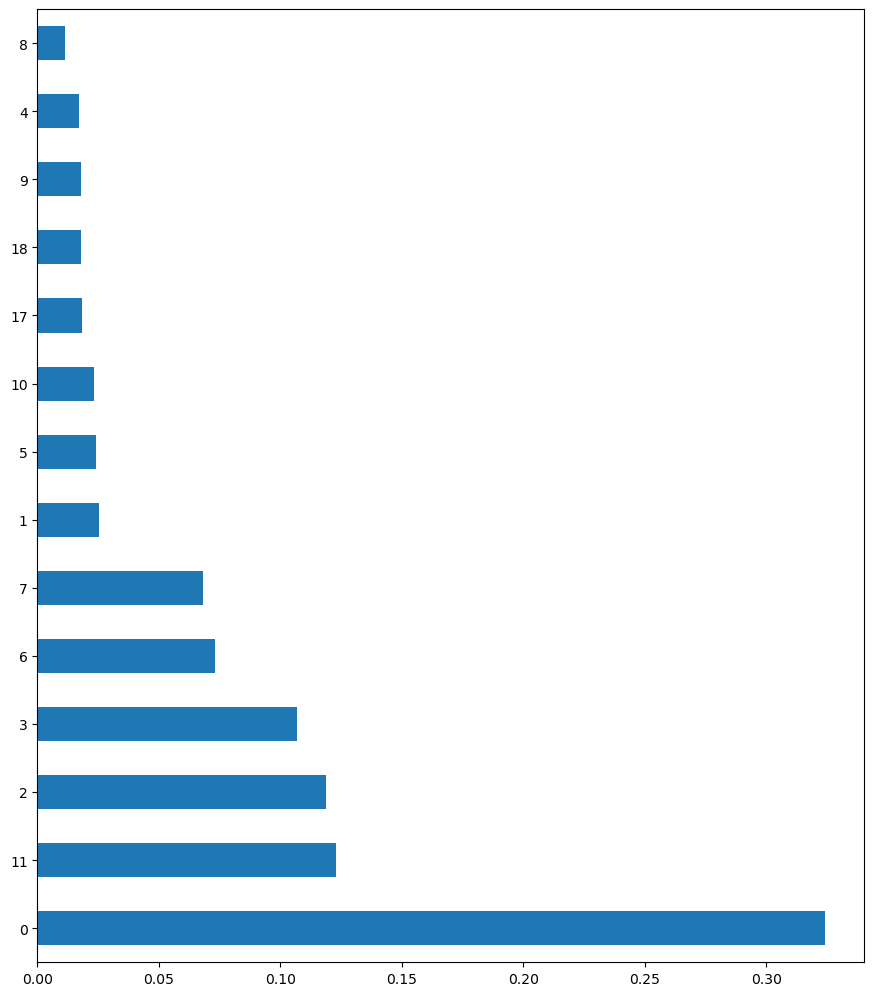

In [17]:
RandomForestModel(X_train_PCA, y_train, X_test_PCA, y_test, 'Mushroom Dataset, PCA 25 Features', ['Edible', 'Poisonous'], 50)
RandomForestModel(X_train_PCA, y_train, X_test_PCA, y_test, 'Mushroom Dataset, PCA 25 Features', ['Edible', 'Poisonous'], 25)
RandomForestModel(X_train_PCA, y_train, X_test_PCA, y_test, 'Mushroom Dataset, PCA 25 Features', ['Edible', 'Poisonous'], 10)
RandomForestModel(X_train_PCA, y_train, X_test_PCA, y_test, 'Mushroom Dataset, PCA 25 Features', ['Edible', 'Poisonous'], 5)

C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[841   1]
 [ 38 745]]


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[839   3]
 [ 39 744]]


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   0 3133]]
Confusion matrix, without normalization
[[839   3]
 [ 42 741]]


C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1050070883.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x, Y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[3366    0]
 [   1 3132]]
Confusion matrix, without normalization
[[817  25]
 [ 39 744]]


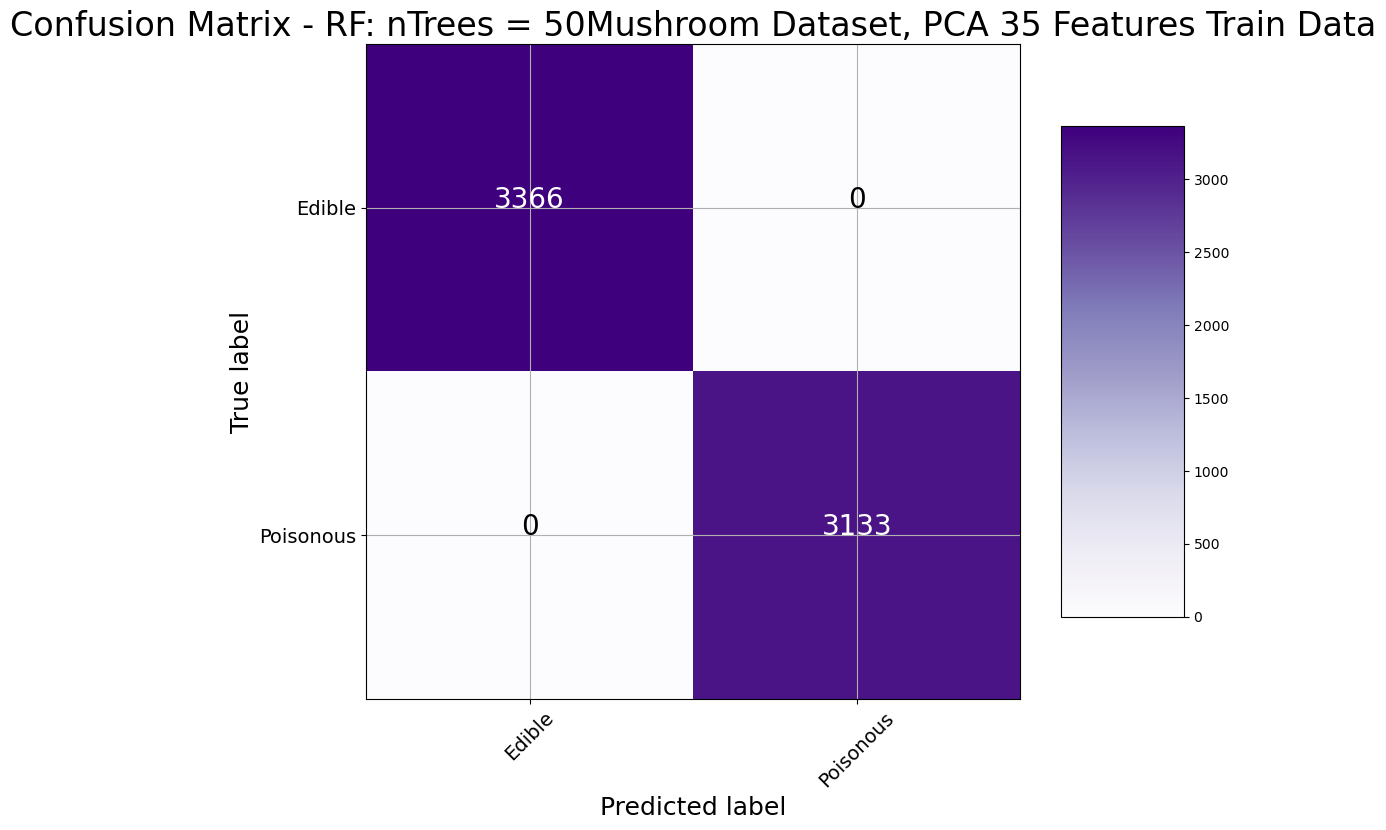

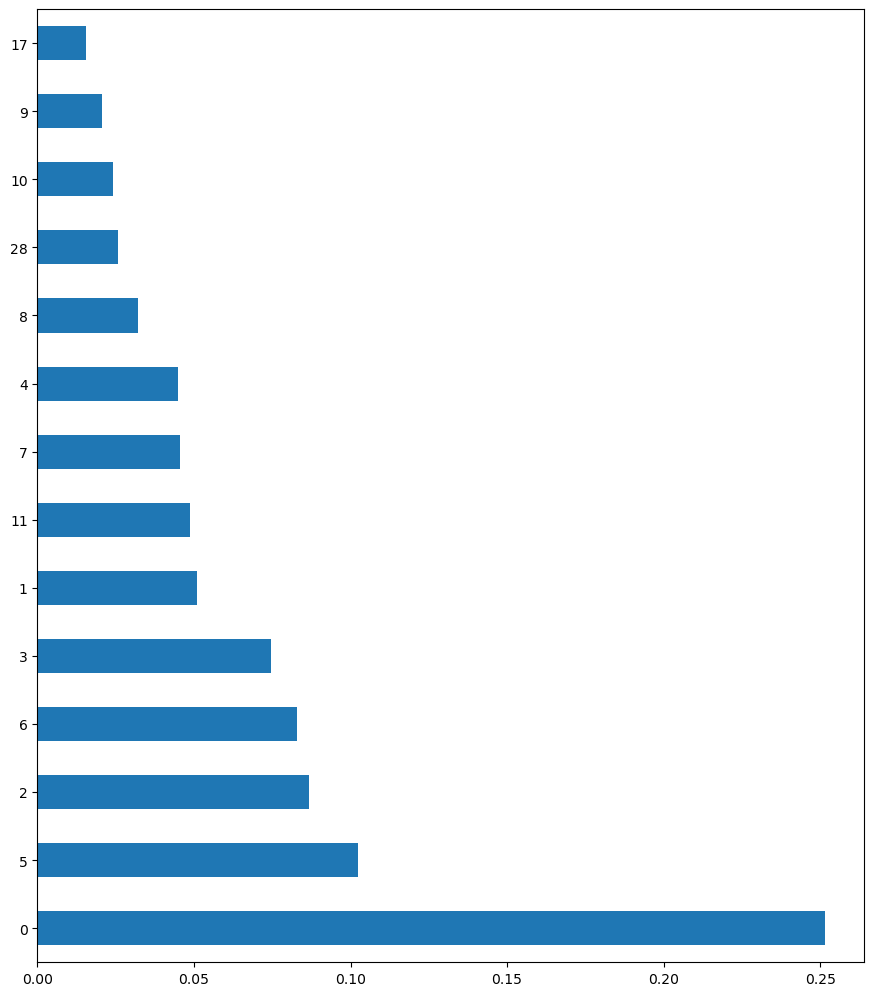

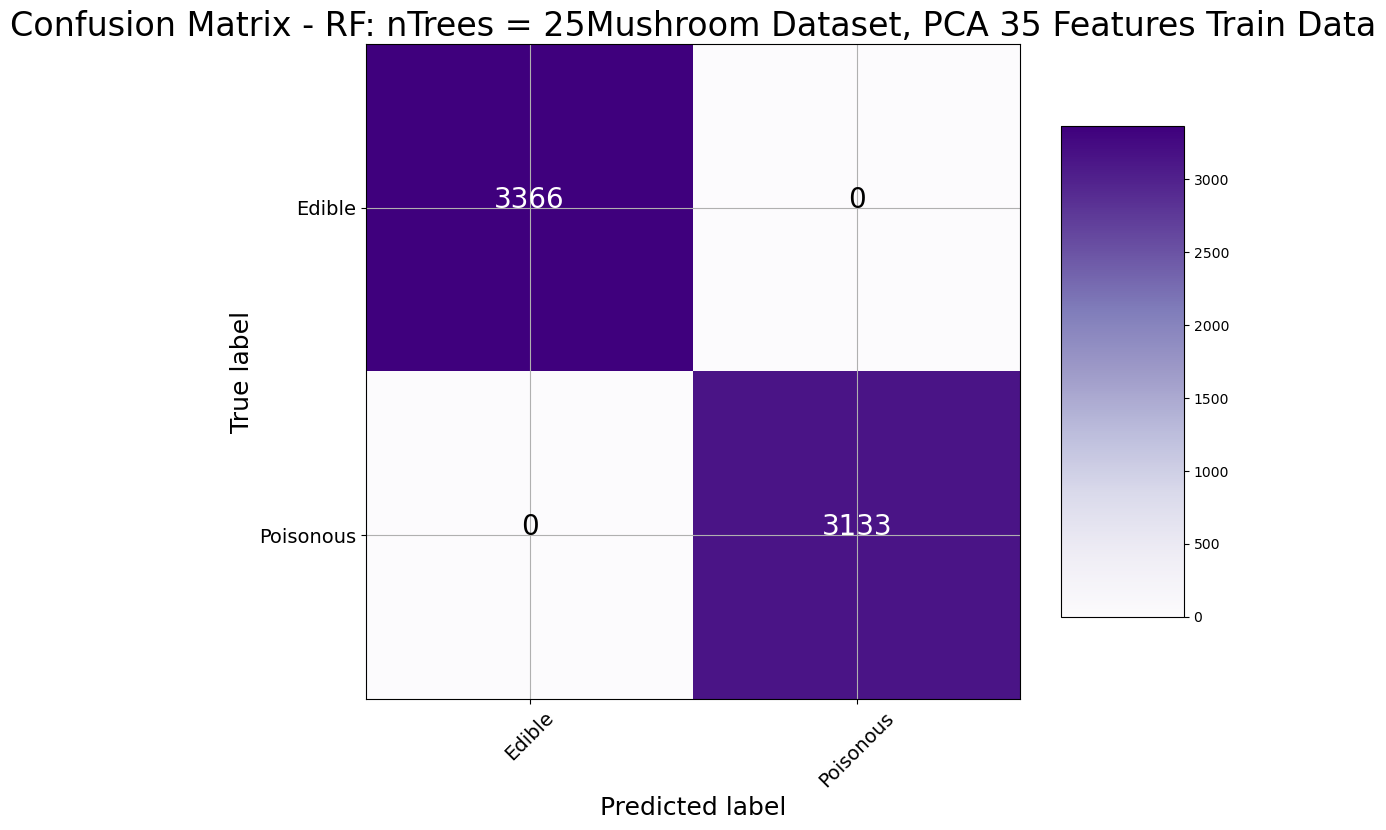

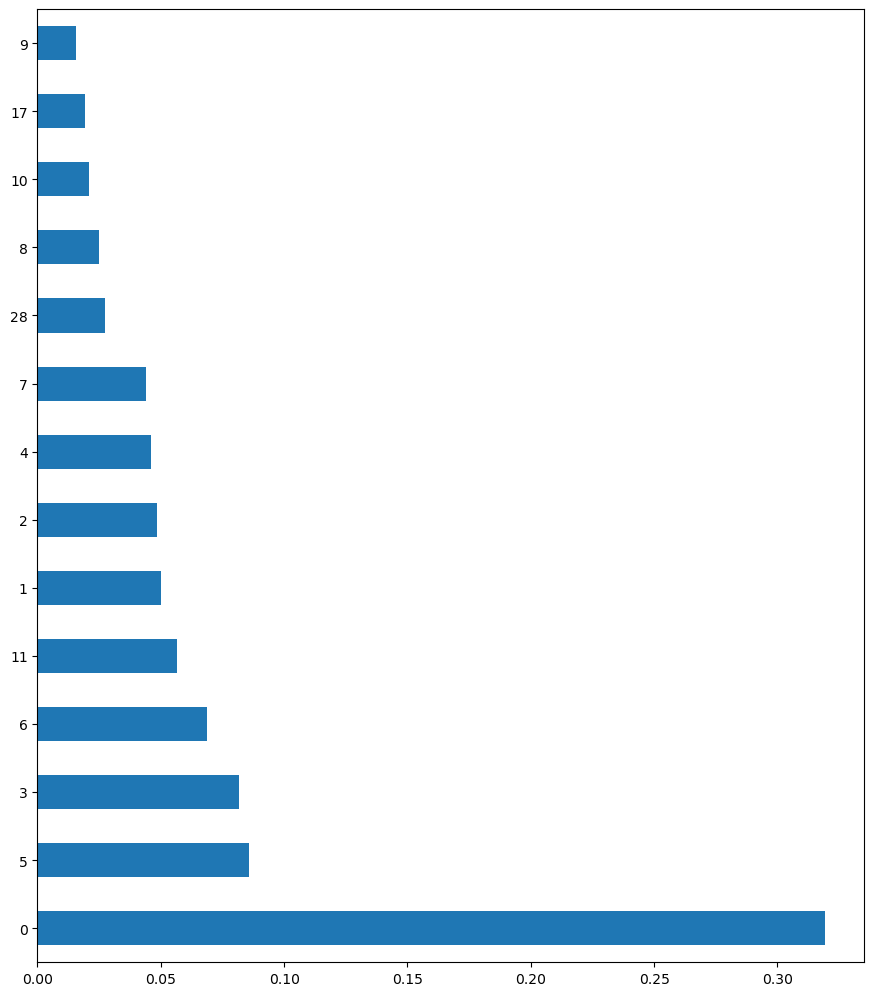

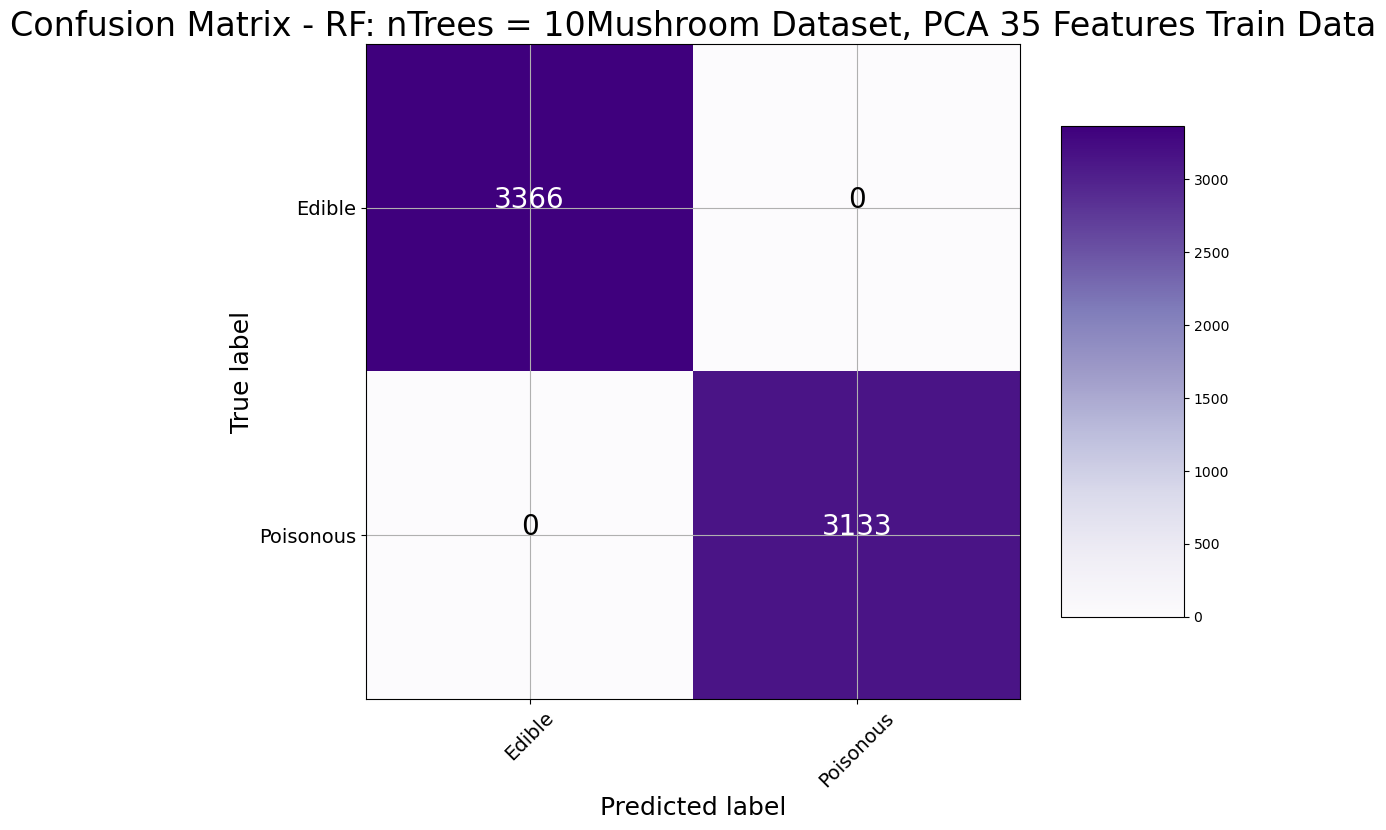

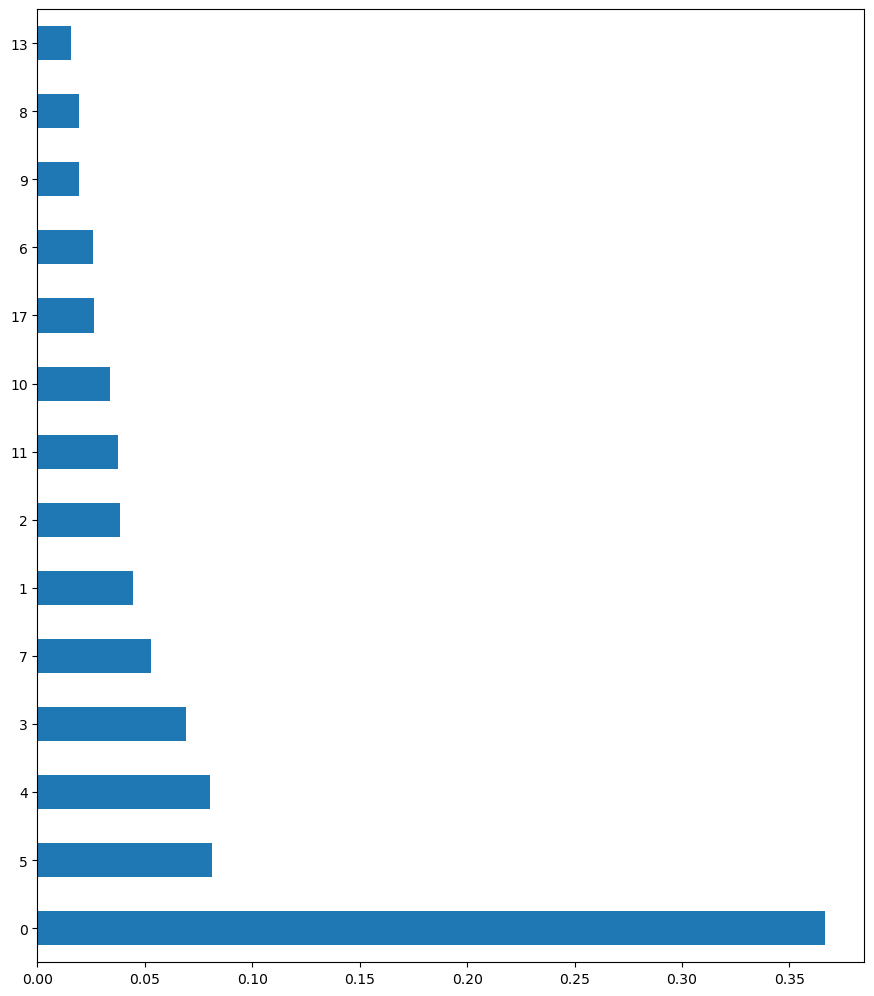

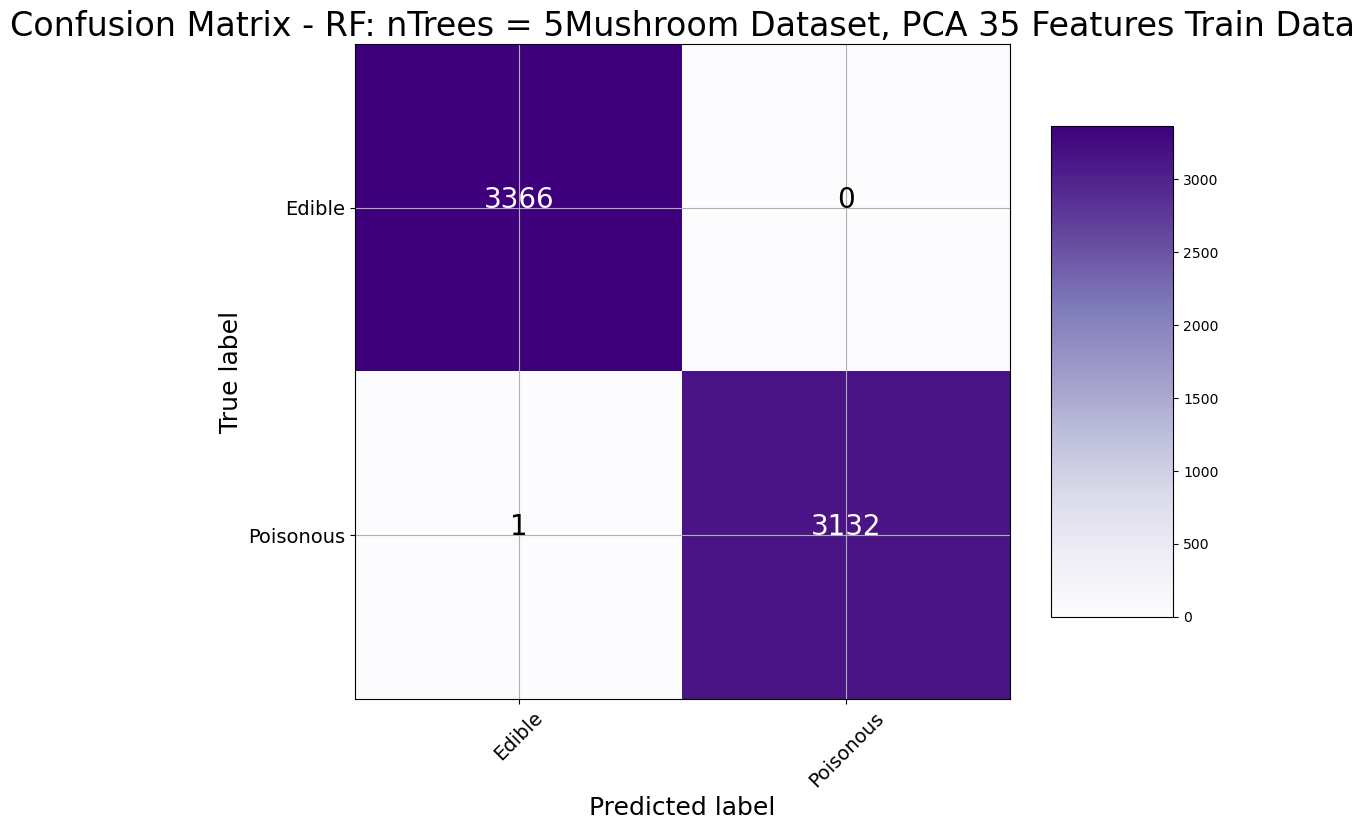

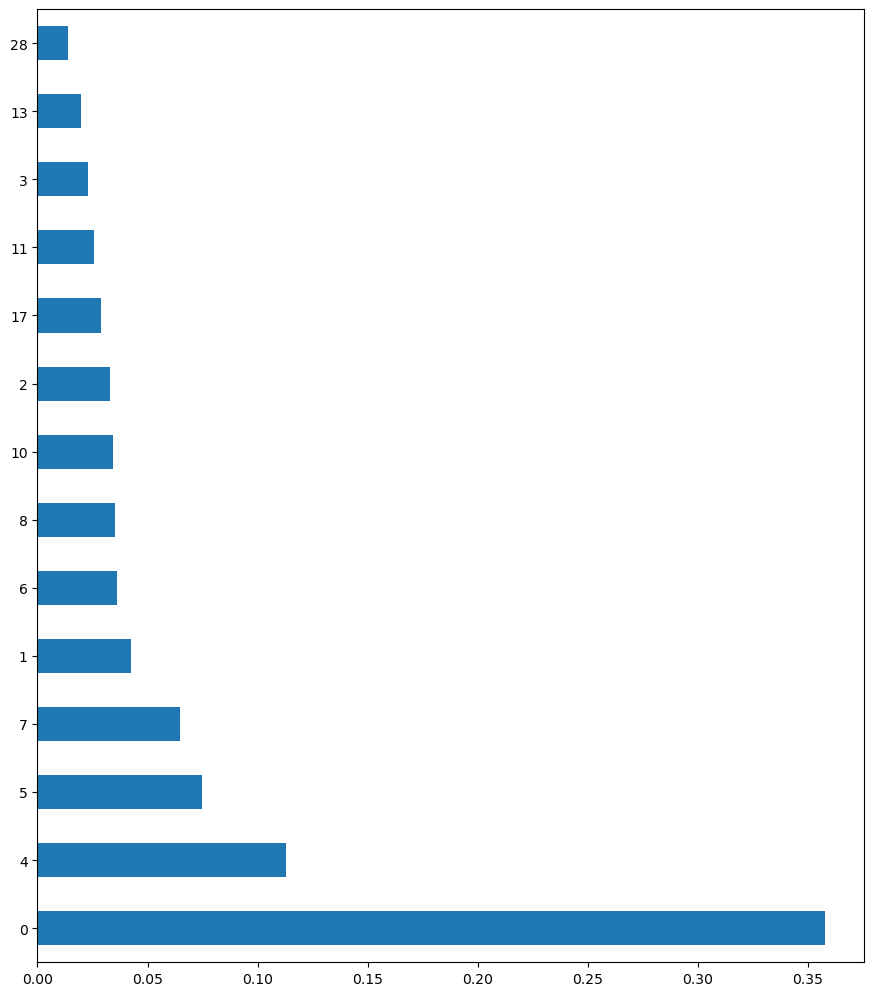

In [18]:
# Performing PCA on the train and test splits
numFeatures = 35

X_train_PCA = PricinpalComponent(X_train, numFeatures)
X_test_PCA = PricinpalComponent(X_test, numFeatures)

RandomForestModel(X_train_PCA, y_train, X_test_PCA, y_test, 'Mushroom Dataset, PCA 35 Features', ['Edible', 'Poisonous'], 50)
RandomForestModel(X_train_PCA, y_train, X_test_PCA, y_test, 'Mushroom Dataset, PCA 35 Features', ['Edible', 'Poisonous'], 25)
RandomForestModel(X_train_PCA, y_train, X_test_PCA, y_test, 'Mushroom Dataset, PCA 35 Features', ['Edible', 'Poisonous'], 10)
RandomForestModel(X_train_PCA, y_train, X_test_PCA, y_test, 'Mushroom Dataset, PCA 35 Features', ['Edible', 'Poisonous'], 5)

# Feature Selection

C:\Users\leena\AppData\Local\Temp\ipykernel_21112\1627685803.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


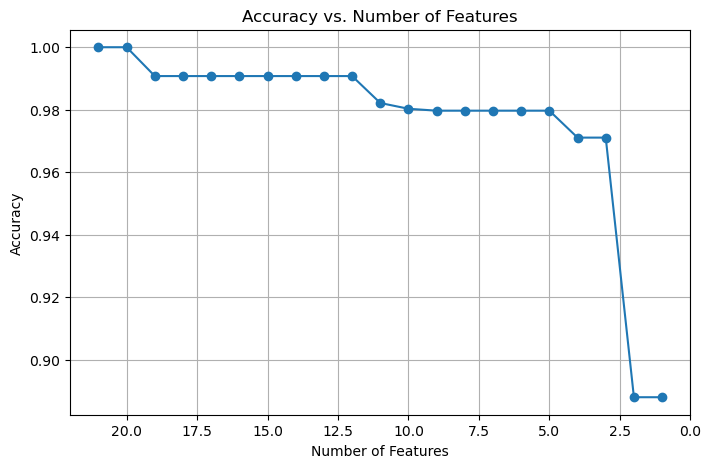

In [19]:
# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Extracting feature importances
feature_importances = rf_classifier.feature_importances_


# Determine the accuracies for subsets of features
accuracies = []
num_features = X.shape[1]
for i in range(num_features, 0, -1):
    # Select top i features
    top_features = feature_importances.argsort()[-i:]
    X_train_subset = X_train.iloc[:, top_features]
    X_test_subset = X_test.iloc[:, top_features]
    
    # Train and test the classifier
    rf_classifier.fit(X_train_subset, y_train.values.ravel())
    accuracy = rf_classifier.score(X_test_subset, y_test)
    accuracies.append(accuracy)

# Plotting accuracies vs. number of features
plt.figure(figsize=(8, 5))
plt.plot(range(num_features, 0, -1), accuracies, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Features')
plt.gca().invert_xaxis()  # Invert x-axis to show decreasing number of features
plt.grid(True)
plt.show()


# Deep learning

In [20]:
import tensorflow as tf
from keras.optimizers import SGD
from tensorflow.keras.layers import Dense

n_features = X_train.shape[1]


model = tf.keras.Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])  # loss = binary crossentropy appropriate for binary classification

# fit the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

# make a prediction

ModelMetrics.append(['Mushroom Dataset',
                     'MLP, 20 epochs', 
                     metrics.accuracy_score(y_train, model.predict(X_train).round()), 
                     metrics.f1_score(y_train, model.predict(X_train).round(), average='weighted'),
                     metrics.accuracy_score(y_test, model.predict(X_test).round()), 
                     metrics.f1_score(y_test, model.predict(X_test).round(), average='weighted')])



Epoch 1/20


C:\Users\leena\anaconda3\envs\MSIA\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8634 - loss: 0.3334
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9936 - loss: 0.0258
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9982 - loss: 0.0090
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9991 - loss: 0.0047
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0031
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 9/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 10/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 7.8551e-04
Epoch 11/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 6.7535e-04
Epoch 12/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - 

In [21]:
print(model.predict(X_train).round())

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [22]:
# Turning model metrics into a dataframe

ModelMetricsDF = pd.DataFrame(ModelMetrics, columns=['Dataset',
                                                     'Model', 
                                                     'Train Accuracy', 
                                                     'Train F1 Score',
                                                     'Test Accuracy',
                                                     'Test F1 Score'])

ModelMetricsDF.sort_values(by = 'Test Accuracy', inplace = True, axis = 0)

ModelMetricsDF.head(20)

ModelMetricsDF.to_csv('modelMetric')

In [25]:
ModelMetricsDF.head(50)

,Dataset,Model,Train Accuracy,Train F1 Score,Test Accuracy,Test F1 Score
9,"Mushroom Dataset, PCA 25 Features",RF: nTrees = 5,0.999846,0.999846,0.956923,0.956912
13,"Mushroom Dataset, PCA 35 Features",RF: nTrees = 5,0.999846,0.999846,0.960615,0.960600
6,"Mushroom Dataset, PCA 25 Features",RF: nTrees = 50,1.000000,1.000000,0.967385,0.967319
12,"Mushroom Dataset, PCA 35 Features",RF: nTrees = 10,1.000000,1.000000,0.972308,0.972267
8,"Mushroom Dataset, PCA 25 Features",RF: nTrees = 10,1.000000,1.000000,0.974154,0.974120
11,"Mushroom Dataset, PCA 35 Features",RF: nTrees = 25,1.000000,1.000000,0.974154,0.974120
10,"Mushroom Dataset, PCA 35 Features",RF: nTrees = 50,1.000000,1.000000,0.976000,0.975968
7,"Mushroom Dataset, PCA 25 Features",RF: nTrees = 25,1.000000,1.000000,0.976615,0.976587
0,Mushroom Dataset,SVM - linear kernel,1.000000,1.000000,1.000000,1.000000
1,"Mushroom Dataset, Full Model",RF: nTrees = 50,1.000000,1.000000,1.000000,1.000000


# Model Comparison Graphics

C:\Users\leena\AppData\Local\Temp\ipykernel_21112\3974151471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca25['numTrees'] = [5, 50, 10, 25]
C:\Users\leena\AppData\Local\Temp\ipykernel_21112\3974151471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca25.sort_values(by=['numTrees'], inplace=True)
C:\Users\leena\AppData\Local\Temp\ipykernel_21112\3974151471.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

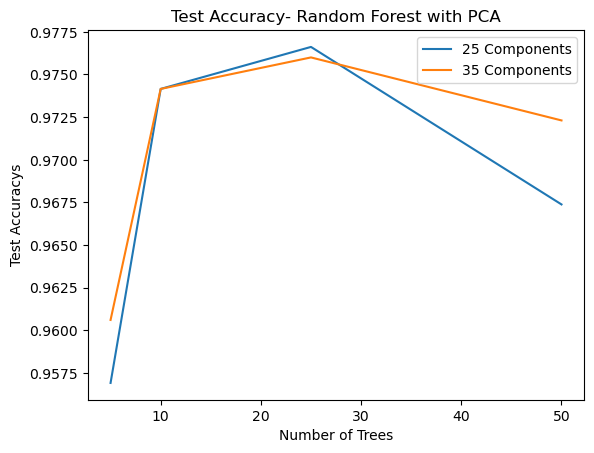

In [40]:
pca25 = ModelMetricsDF[ModelMetricsDF['Dataset']=='Mushroom Dataset, PCA 25 Features']
pca25['numTrees'] = [5, 50, 10, 25]
pca25.sort_values(by=['numTrees'], inplace=True)

pca35 = ModelMetricsDF[ModelMetricsDF['Dataset']=='Mushroom Dataset, PCA 35 Features']
pca35['numTrees'] = [5, 50, 10, 25]
pca35.sort_values(by=['numTrees'], inplace=True)

plt.plot(pca25['numTrees'],pca25['Test Accuracy'], label = '25 Components')
plt.plot(pca35['numTrees'],pca35['Test Accuracy'], label = '35 Components')

#plt.plot(pca25['numTrees'],pca25['Test F1 Score'], label = 'F1 Score')
plt.ylabel('Test Accuracys')
plt.xlabel('Number of Trees')
plt.title('Test Accuracy- Random Forest with PCA')
plt.legend()



In [43]:
ModelMetricsDF.head(30)


,Dataset,Model,Train Accuracy,Train F1 Score,Test Accuracy,Test F1 Score
9,"Mushroom Dataset, PCA 25 Features",RF: nTrees = 5,0.999846,0.999846,0.956923,0.956912
13,"Mushroom Dataset, PCA 35 Features",RF: nTrees = 5,0.999846,0.999846,0.960615,0.960600
6,"Mushroom Dataset, PCA 25 Features",RF: nTrees = 50,1.000000,1.000000,0.967385,0.967319
12,"Mushroom Dataset, PCA 35 Features",RF: nTrees = 10,1.000000,1.000000,0.972308,0.972267
8,"Mushroom Dataset, PCA 25 Features",RF: nTrees = 10,1.000000,1.000000,0.974154,0.974120
11,"Mushroom Dataset, PCA 35 Features",RF: nTrees = 25,1.000000,1.000000,0.974154,0.974120
10,"Mushroom Dataset, PCA 35 Features",RF: nTrees = 50,1.000000,1.000000,0.976000,0.975968
7,"Mushroom Dataset, PCA 25 Features",RF: nTrees = 25,1.000000,1.000000,0.976615,0.976587
0,Mushroom Dataset,SVM - linear kernel,1.000000,1.000000,1.000000,1.000000
1,"Mushroom Dataset, Full Model",RF: nTrees = 50,1.000000,1.000000,1.000000,1.000000
